In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import random

from dataset import get_dataset
from metrics import Metrics

In [2]:
_, _, data_np = get_dataset(name="electricity", window_len=1, cxt_len=1, pred_len=1)

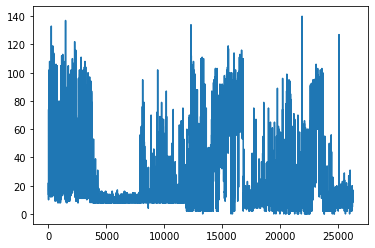

In [3]:
plt.plot(data_np[0])

In [4]:
pred_len = 100
window_len = 400
sample_len = 800

# only train with the first few observations of each time series
train_ds = torch.tensor(data_np[:, :sample_len-pred_len])
test_ds = torch.tensor(data_np[:, sample_len-pred_len-window_len:sample_len])

In [5]:
train_mean = []
train_sd = []
for i in range(train_ds.shape[0]):
    sample_mean = torch.mean(train_ds[i])
    sample_sd = torch.std(train_ds[i], unbiased = True)
    train_mean.append(sample_mean)
    train_sd.append(sample_sd)
    train_ds[i] = (train_ds[i] - sample_mean) / sample_sd
    test_ds[i] = (test_ds[i] - sample_mean) / sample_sd

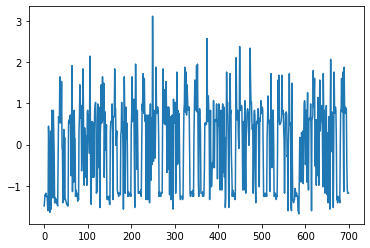

In [6]:
plt.plot(train_ds[0].detach().numpy())

In [7]:
def create_inout_sequences(input_data, window_len, pred_len = 1):
    L = len(input_data)
    x = torch.empty([L-window_len, window_len ,1])
    y = torch.empty([L-window_len ,1])
    for i in range(L-window_len):
        x[i, :, 0] = input_data[i:i+window_len]
        y[i, 0] = input_data[i+window_len:i+window_len+pred_len]
    return x, y

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_outputs = 2, input_size = 1, hidden_size = 50, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.num_outputs = num_outputs
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=.5)
        
        self.fc = nn.Linear(hidden_size, num_outputs)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda()
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda()
        # Propagate input through LSTM
        output, (h_out, _) = self.lstm(x, (h_0, c_0))
        output = output[:, -1, :]
        out = self.fc(output)
        out[:, 1] = torch.log(1 + torch.exp(out[:, 1])) # variance
        
        return out, output

In [9]:
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + torch.pow(y - mean, 2)/var).sum()

In [14]:
def contrastive_loss(x, feature):
    """
    x: k by 3 by d tensor
    """
    m = nn.ReLU()
    k = x.shape[0]
    d = x.shape[2]
    weight = torch.from_numpy(1/np.sqrt(np.arange(d,0,-1))).repeat([k, 1]).cuda()
    distance_x01 = ((x[:, 0, :] - x[:, 1, :]) * weight).norm(dim = 1)
    distance_x02 = ((x[:, 0, :] - x[:, 2, :]) * weight).norm(dim = 1)
    distance_f01 = (feature[:, 0, :] - feature[:, 1, :]).norm(dim = 1)
    distance_f02 = (feature[:, 0, :] - feature[:, 2, :]).norm(dim = 1)
    loss = torch.sum((distance_x01 - distance_x02 < 0) * m(distance_f01 - distance_f02)) + torch.sum((distance_x02 - distance_x01 < 0) * m(distance_f02 - distance_f01))
    return loss

In [11]:
def create_kernel_sequences(input_data, index, start, window_len):
    n = len(index) * 3
    x = torch.empty([n, window_len,1])
    for i in range(len(index)):
        for j in range(3):
            x[i*3 + j, :, 0] = input_data[index[i][j], start[i][j]:start[i][j]+window_len]
    return x

In [16]:
num_epochs = 30
learning_rate = 0.003
batch_size = 100

input_size = 1
hidden_size = 300
num_layers = 2
num_outputs = 2

n_pairs = 100

lstm = LSTM(num_outputs, input_size, hidden_size, num_layers).cuda()
lstm.train()

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(train_ds)):
        optimizer.zero_grad()
        nllk_loss = 0
        train_x, train_y = create_inout_sequences(train_ds[i], window_len)
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        num_batch = math.ceil(train_x.shape[0] / batch_size)
        for j in range(num_batch):
            outputs, _ = lstm(train_x[(j * batch_size) : ((j+1) * batch_size), :, :])
            nllk_loss += NLLloss(train_y[(j * batch_size) : ((j+1) * batch_size), :].squeeze(1), outputs[:, 0], outputs[:, 1])
        nllk_loss /= train_x.shape[0]
        
        index = [random.sample(range(len(train_ds)), 3) for _ in range(n_pairs)]
        start = [random.sample(range(sample_len - pred_len - window_len), 3) for _ in range(n_pairs)]
        kernel_x = create_kernel_sequences(train_ds, index, start, window_len).cuda()
        _, feature = lstm(kernel_x)
        kernel_x = kernel_x.squeeze(dim = 2).reshape([n_pairs, 3, -1])
        feature = feature.reshape([n_pairs, 3, -1])
        kernel_loss = contrastive_loss(kernel_x, feature)
        
        loss = nllk_loss + kernel_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        print("Epoch: %d, series: %d, nllk loss: %1.5f, kernel loss: %1.5f" % (epoch, i, nllk_loss.item(), kernel_loss.item()))
    print("Epoch: %d, total loss: %1.5f" % (epoch, total_loss))

Epoch: 0, series: 0, nllk loss: 1.02879, kernel loss: 0.47145
Epoch: 0, series: 1, nllk loss: 0.74155, kernel loss: 0.19170
Epoch: 0, series: 2, nllk loss: 1.21650, kernel loss: 0.47468
Epoch: 0, series: 3, nllk loss: 1.01623, kernel loss: 0.13728
Epoch: 0, series: 4, nllk loss: 1.08677, kernel loss: 0.19101
Epoch: 0, series: 5, nllk loss: 1.04421, kernel loss: 0.31109
Epoch: 0, series: 6, nllk loss: 1.21238, kernel loss: 0.45881
Epoch: 0, series: 7, nllk loss: 0.97882, kernel loss: 0.44067
Epoch: 0, series: 8, nllk loss: 0.96377, kernel loss: 0.48107
Epoch: 0, series: 9, nllk loss: 0.84289, kernel loss: 0.32376
Epoch: 0, series: 10, nllk loss: 0.96300, kernel loss: 0.63226
Epoch: 0, series: 11, nllk loss: 1.00510, kernel loss: 0.50541
Epoch: 0, series: 12, nllk loss: 0.92294, kernel loss: 0.47395
Epoch: 0, series: 13, nllk loss: 0.96609, kernel loss: 0.40311
Epoch: 0, series: 14, nllk loss: 0.95978, kernel loss: 0.34559
Epoch: 0, series: 15, nllk loss: 0.93255, kernel loss: 0.50938
Ep

Epoch: 0, series: 130, nllk loss: -0.36636, kernel loss: 0.40662
Epoch: 0, series: 131, nllk loss: 0.33142, kernel loss: 0.26222
Epoch: 0, series: 132, nllk loss: 0.13939, kernel loss: 1.17935
Epoch: 0, series: 133, nllk loss: -0.53598, kernel loss: 1.14025
Epoch: 0, series: 134, nllk loss: -0.46590, kernel loss: 0.53955
Epoch: 0, series: 135, nllk loss: -0.62925, kernel loss: 1.00118
Epoch: 0, series: 136, nllk loss: -0.26913, kernel loss: 0.55973
Epoch: 0, series: 137, nllk loss: -0.69976, kernel loss: 0.45681
Epoch: 0, series: 138, nllk loss: -0.73359, kernel loss: 0.69714
Epoch: 0, series: 139, nllk loss: -0.69255, kernel loss: 0.63773
Epoch: 0, series: 140, nllk loss: -0.68181, kernel loss: 0.26949
Epoch: 0, series: 141, nllk loss: -0.59760, kernel loss: 0.75234
Epoch: 0, series: 142, nllk loss: -0.40873, kernel loss: 0.84215
Epoch: 0, series: 143, nllk loss: -0.55753, kernel loss: 0.46994
Epoch: 0, series: 144, nllk loss: -0.56452, kernel loss: 0.71186
Epoch: 0, series: 145, nllk

Epoch: 0, series: 257, nllk loss: -1.36795, kernel loss: 0.11403
Epoch: 0, series: 258, nllk loss: -1.36427, kernel loss: 0.46407
Epoch: 0, series: 259, nllk loss: -0.94563, kernel loss: 0.17587
Epoch: 0, series: 260, nllk loss: -1.19963, kernel loss: 0.24147
Epoch: 0, series: 261, nllk loss: -1.49662, kernel loss: 0.23763
Epoch: 0, series: 262, nllk loss: -1.59239, kernel loss: 0.23995
Epoch: 0, series: 263, nllk loss: -0.38442, kernel loss: 0.59027
Epoch: 0, series: 264, nllk loss: -1.37761, kernel loss: 0.37469
Epoch: 0, series: 265, nllk loss: -1.50021, kernel loss: 0.33387
Epoch: 0, series: 266, nllk loss: -1.44817, kernel loss: 0.11991
Epoch: 0, series: 267, nllk loss: -1.56753, kernel loss: 0.35490
Epoch: 0, series: 268, nllk loss: -1.48672, kernel loss: 0.21878
Epoch: 0, series: 269, nllk loss: -0.88465, kernel loss: 0.12024
Epoch: 0, series: 270, nllk loss: -1.16934, kernel loss: 0.14781
Epoch: 0, series: 271, nllk loss: -1.32444, kernel loss: 0.19213
Epoch: 0, series: 272, nl

Epoch: 1, series: 63, nllk loss: -0.93152, kernel loss: 0.36238
Epoch: 1, series: 64, nllk loss: -0.37974, kernel loss: 0.29336
Epoch: 1, series: 65, nllk loss: -0.98028, kernel loss: 0.14448
Epoch: 1, series: 66, nllk loss: -0.84709, kernel loss: 0.14229
Epoch: 1, series: 67, nllk loss: -0.87392, kernel loss: 0.40331
Epoch: 1, series: 68, nllk loss: -0.39398, kernel loss: 0.31988
Epoch: 1, series: 69, nllk loss: -0.96881, kernel loss: 0.27238
Epoch: 1, series: 70, nllk loss: -1.11533, kernel loss: 0.44956
Epoch: 1, series: 71, nllk loss: -1.10394, kernel loss: 0.26993
Epoch: 1, series: 72, nllk loss: -1.20119, kernel loss: 0.05096
Epoch: 1, series: 73, nllk loss: -0.87102, kernel loss: 0.41421
Epoch: 1, series: 74, nllk loss: -1.22664, kernel loss: 0.08854
Epoch: 1, series: 75, nllk loss: -1.08643, kernel loss: 0.34546
Epoch: 1, series: 76, nllk loss: -1.06928, kernel loss: 0.12194
Epoch: 1, series: 77, nllk loss: -0.69710, kernel loss: 0.19118
Epoch: 1, series: 78, nllk loss: -1.0284

Epoch: 1, series: 190, nllk loss: -1.61778, kernel loss: 0.14060
Epoch: 1, series: 191, nllk loss: -1.67327, kernel loss: 0.20001
Epoch: 1, series: 192, nllk loss: -1.58131, kernel loss: 0.27935
Epoch: 1, series: 193, nllk loss: -1.24695, kernel loss: 0.19415
Epoch: 1, series: 194, nllk loss: -0.95943, kernel loss: 0.09121
Epoch: 1, series: 195, nllk loss: -1.80704, kernel loss: 0.28123
Epoch: 1, series: 196, nllk loss: -1.50130, kernel loss: 0.43272
Epoch: 1, series: 197, nllk loss: -1.56265, kernel loss: 0.17646
Epoch: 1, series: 198, nllk loss: -1.68981, kernel loss: 0.46544
Epoch: 1, series: 199, nllk loss: -1.62898, kernel loss: 0.18592
Epoch: 1, series: 200, nllk loss: -1.57837, kernel loss: 0.10284
Epoch: 1, series: 201, nllk loss: -1.74762, kernel loss: 0.27062
Epoch: 1, series: 202, nllk loss: -1.54053, kernel loss: 0.10139
Epoch: 1, series: 203, nllk loss: -1.67652, kernel loss: 0.09341
Epoch: 1, series: 204, nllk loss: -0.93435, kernel loss: 0.23675
Epoch: 1, series: 205, nl

Epoch: 1, series: 317, nllk loss: 0.28790, kernel loss: 0.39556
Epoch: 1, series: 318, nllk loss: 0.69770, kernel loss: 0.80396
Epoch: 1, series: 319, nllk loss: -0.54191, kernel loss: 0.30771
Epoch: 1, series: 320, nllk loss: -0.60527, kernel loss: 0.30995
Epoch: 1, total loss: -262.64288
Epoch: 2, series: 0, nllk loss: 1.70096, kernel loss: 0.31284
Epoch: 2, series: 1, nllk loss: -0.34425, kernel loss: 0.22107
Epoch: 2, series: 2, nllk loss: 0.26324, kernel loss: 0.22529
Epoch: 2, series: 3, nllk loss: -0.52933, kernel loss: 0.21822
Epoch: 2, series: 4, nllk loss: -0.42558, kernel loss: 0.28144
Epoch: 2, series: 5, nllk loss: -0.47674, kernel loss: 0.11464
Epoch: 2, series: 6, nllk loss: -0.20461, kernel loss: 0.17497
Epoch: 2, series: 7, nllk loss: -0.46911, kernel loss: 0.14931
Epoch: 2, series: 8, nllk loss: -0.06273, kernel loss: 0.22975
Epoch: 2, series: 9, nllk loss: -0.28472, kernel loss: 0.25910
Epoch: 2, series: 10, nllk loss: -0.59055, kernel loss: 0.17599
Epoch: 2, series:

Epoch: 2, series: 124, nllk loss: -1.27020, kernel loss: 0.31732
Epoch: 2, series: 125, nllk loss: -1.21273, kernel loss: 0.26851
Epoch: 2, series: 126, nllk loss: -1.26651, kernel loss: 0.18226
Epoch: 2, series: 127, nllk loss: -1.22798, kernel loss: 0.14645
Epoch: 2, series: 128, nllk loss: -0.87459, kernel loss: 0.08261
Epoch: 2, series: 129, nllk loss: -0.60253, kernel loss: 0.14901
Epoch: 2, series: 130, nllk loss: -1.04095, kernel loss: 0.27713
Epoch: 2, series: 131, nllk loss: 0.31901, kernel loss: 0.14754
Epoch: 2, series: 132, nllk loss: -0.08416, kernel loss: 0.11134
Epoch: 2, series: 133, nllk loss: -0.78771, kernel loss: 0.16246
Epoch: 2, series: 134, nllk loss: -0.79159, kernel loss: 0.38068
Epoch: 2, series: 135, nllk loss: -1.25510, kernel loss: 0.20808
Epoch: 2, series: 136, nllk loss: -1.13664, kernel loss: 0.07195
Epoch: 2, series: 137, nllk loss: -1.36946, kernel loss: 0.06246
Epoch: 2, series: 138, nllk loss: -1.39700, kernel loss: 0.08142
Epoch: 2, series: 139, nll

Epoch: 2, series: 251, nllk loss: -0.91372, kernel loss: 0.12592
Epoch: 2, series: 252, nllk loss: -0.62679, kernel loss: 0.17056
Epoch: 2, series: 253, nllk loss: -1.52033, kernel loss: 0.13720
Epoch: 2, series: 254, nllk loss: -1.91248, kernel loss: 0.27705
Epoch: 2, series: 255, nllk loss: -1.76988, kernel loss: 0.04529
Epoch: 2, series: 256, nllk loss: -1.40861, kernel loss: 0.07824
Epoch: 2, series: 257, nllk loss: -1.71696, kernel loss: 0.37706
Epoch: 2, series: 258, nllk loss: -1.75454, kernel loss: 0.07326
Epoch: 2, series: 259, nllk loss: -1.33312, kernel loss: 0.14020
Epoch: 2, series: 260, nllk loss: -1.57041, kernel loss: 0.15860
Epoch: 2, series: 261, nllk loss: -1.87928, kernel loss: 0.07013
Epoch: 2, series: 262, nllk loss: -1.97539, kernel loss: 0.28346
Epoch: 2, series: 263, nllk loss: -0.54498, kernel loss: 0.16046
Epoch: 2, series: 264, nllk loss: -1.67314, kernel loss: 0.23632
Epoch: 2, series: 265, nllk loss: -1.77240, kernel loss: 0.15681
Epoch: 2, series: 266, nl

Epoch: 3, series: 57, nllk loss: -1.09257, kernel loss: 0.19145
Epoch: 3, series: 58, nllk loss: -1.26995, kernel loss: 0.46250
Epoch: 3, series: 59, nllk loss: -0.88859, kernel loss: 0.09682
Epoch: 3, series: 60, nllk loss: -1.00940, kernel loss: 0.13061
Epoch: 3, series: 61, nllk loss: -1.35533, kernel loss: 0.16645
Epoch: 3, series: 62, nllk loss: -1.35351, kernel loss: 0.19639
Epoch: 3, series: 63, nllk loss: -1.33704, kernel loss: 0.42490
Epoch: 3, series: 64, nllk loss: -0.91498, kernel loss: 0.13177
Epoch: 3, series: 65, nllk loss: -1.36286, kernel loss: 0.11155
Epoch: 3, series: 66, nllk loss: -1.25461, kernel loss: 0.30261
Epoch: 3, series: 67, nllk loss: -1.08378, kernel loss: 0.43154
Epoch: 3, series: 68, nllk loss: -0.54849, kernel loss: 0.28795
Epoch: 3, series: 69, nllk loss: -1.15894, kernel loss: 0.02933
Epoch: 3, series: 70, nllk loss: -1.22015, kernel loss: 0.27581
Epoch: 3, series: 71, nllk loss: -1.27844, kernel loss: 0.38309
Epoch: 3, series: 72, nllk loss: -1.5457

Epoch: 3, series: 184, nllk loss: -1.64908, kernel loss: 0.18260
Epoch: 3, series: 185, nllk loss: -1.61540, kernel loss: 0.18793
Epoch: 3, series: 186, nllk loss: -1.99407, kernel loss: 0.25535
Epoch: 3, series: 187, nllk loss: -2.14688, kernel loss: 0.66967
Epoch: 3, series: 188, nllk loss: -1.34059, kernel loss: 0.15494
Epoch: 3, series: 189, nllk loss: -1.08736, kernel loss: 0.09049
Epoch: 3, series: 190, nllk loss: -1.55291, kernel loss: 0.14188
Epoch: 3, series: 191, nllk loss: -1.60751, kernel loss: 0.20928
Epoch: 3, series: 192, nllk loss: -1.78570, kernel loss: 0.17763
Epoch: 3, series: 193, nllk loss: -1.49933, kernel loss: 0.23783
Epoch: 3, series: 194, nllk loss: -1.14005, kernel loss: 0.04466
Epoch: 3, series: 195, nllk loss: -1.92187, kernel loss: 0.23097
Epoch: 3, series: 196, nllk loss: -1.67460, kernel loss: 0.36025
Epoch: 3, series: 197, nllk loss: -1.81736, kernel loss: 0.11800
Epoch: 3, series: 198, nllk loss: -1.97446, kernel loss: 0.18854
Epoch: 3, series: 199, nl

Epoch: 3, series: 311, nllk loss: -1.15050, kernel loss: 0.14550
Epoch: 3, series: 312, nllk loss: -1.39190, kernel loss: 0.20422
Epoch: 3, series: 313, nllk loss: -1.48976, kernel loss: 0.22281
Epoch: 3, series: 314, nllk loss: -1.61059, kernel loss: 0.12271
Epoch: 3, series: 315, nllk loss: -0.87313, kernel loss: 0.25981
Epoch: 3, series: 316, nllk loss: -1.21792, kernel loss: 0.35062
Epoch: 3, series: 317, nllk loss: 0.30630, kernel loss: 0.17237
Epoch: 3, series: 318, nllk loss: 1.04981, kernel loss: 0.05954
Epoch: 3, series: 319, nllk loss: -0.75066, kernel loss: 0.28418
Epoch: 3, series: 320, nllk loss: -0.92555, kernel loss: 0.56059
Epoch: 3, total loss: -339.49702
Epoch: 4, series: 0, nllk loss: 2.63334, kernel loss: 0.32818
Epoch: 4, series: 1, nllk loss: -0.80874, kernel loss: 0.31448
Epoch: 4, series: 2, nllk loss: 0.31358, kernel loss: 0.15447
Epoch: 4, series: 3, nllk loss: -0.85425, kernel loss: 0.11054
Epoch: 4, series: 4, nllk loss: -0.65068, kernel loss: 0.23286
Epoch:

Epoch: 4, series: 118, nllk loss: -1.64506, kernel loss: 0.12654
Epoch: 4, series: 119, nllk loss: -0.52493, kernel loss: 0.31445
Epoch: 4, series: 120, nllk loss: -1.41659, kernel loss: 0.23516
Epoch: 4, series: 121, nllk loss: 0.15325, kernel loss: 0.02010
Epoch: 4, series: 122, nllk loss: -0.42836, kernel loss: 0.02300
Epoch: 4, series: 123, nllk loss: -1.36145, kernel loss: 0.20257
Epoch: 4, series: 124, nllk loss: -1.42922, kernel loss: 0.10421
Epoch: 4, series: 125, nllk loss: -1.30370, kernel loss: 0.05716
Epoch: 4, series: 126, nllk loss: -1.39186, kernel loss: 0.05007
Epoch: 4, series: 127, nllk loss: -1.36082, kernel loss: 0.11522
Epoch: 4, series: 128, nllk loss: -0.93758, kernel loss: 0.17191
Epoch: 4, series: 129, nllk loss: -0.71091, kernel loss: 0.08278
Epoch: 4, series: 130, nllk loss: -1.05766, kernel loss: 0.21850
Epoch: 4, series: 131, nllk loss: 0.42071, kernel loss: 0.26689
Epoch: 4, series: 132, nllk loss: -0.10211, kernel loss: 0.11838
Epoch: 4, series: 133, nllk

Epoch: 4, series: 245, nllk loss: -1.93168, kernel loss: 0.10252
Epoch: 4, series: 246, nllk loss: 0.11214, kernel loss: 0.15261
Epoch: 4, series: 247, nllk loss: -1.58311, kernel loss: 0.09295
Epoch: 4, series: 248, nllk loss: -1.75096, kernel loss: 0.09988
Epoch: 4, series: 249, nllk loss: -1.61186, kernel loss: 0.17469
Epoch: 4, series: 250, nllk loss: -1.56375, kernel loss: 0.36632
Epoch: 4, series: 251, nllk loss: -0.94854, kernel loss: 0.24744
Epoch: 4, series: 252, nllk loss: -0.72390, kernel loss: 0.06673
Epoch: 4, series: 253, nllk loss: -1.62431, kernel loss: 0.06172
Epoch: 4, series: 254, nllk loss: -2.03569, kernel loss: 0.10091
Epoch: 4, series: 255, nllk loss: -1.81456, kernel loss: 0.15412
Epoch: 4, series: 256, nllk loss: -1.38390, kernel loss: 0.26545
Epoch: 4, series: 257, nllk loss: -1.87688, kernel loss: 0.16707
Epoch: 4, series: 258, nllk loss: -1.83285, kernel loss: 0.22294
Epoch: 4, series: 259, nllk loss: -1.50670, kernel loss: 0.11434
Epoch: 4, series: 260, nll

Epoch: 5, series: 51, nllk loss: -1.31936, kernel loss: 0.21434
Epoch: 5, series: 52, nllk loss: -0.46393, kernel loss: 0.00000
Epoch: 5, series: 53, nllk loss: -1.38918, kernel loss: 0.14046
Epoch: 5, series: 54, nllk loss: -1.04802, kernel loss: 0.00829
Epoch: 5, series: 55, nllk loss: -0.91547, kernel loss: 0.16654
Epoch: 5, series: 56, nllk loss: -1.22457, kernel loss: 0.23055
Epoch: 5, series: 57, nllk loss: -1.21924, kernel loss: 0.04928
Epoch: 5, series: 58, nllk loss: -1.33554, kernel loss: 0.00000
Epoch: 5, series: 59, nllk loss: -0.92845, kernel loss: 0.04133
Epoch: 5, series: 60, nllk loss: -0.97439, kernel loss: 0.25498
Epoch: 5, series: 61, nllk loss: -1.57706, kernel loss: 0.10118
Epoch: 5, series: 62, nllk loss: -1.58265, kernel loss: 0.10241
Epoch: 5, series: 63, nllk loss: -1.44046, kernel loss: 0.10789
Epoch: 5, series: 64, nllk loss: -0.93519, kernel loss: 0.09312
Epoch: 5, series: 65, nllk loss: -1.42920, kernel loss: 0.00728
Epoch: 5, series: 66, nllk loss: -1.3669

Epoch: 5, series: 178, nllk loss: -1.39036, kernel loss: 0.18716
Epoch: 5, series: 179, nllk loss: -1.87228, kernel loss: 0.24834
Epoch: 5, series: 180, nllk loss: -1.88717, kernel loss: 0.17085
Epoch: 5, series: 181, nllk loss: -2.09509, kernel loss: 0.01874
Epoch: 5, series: 182, nllk loss: -1.87136, kernel loss: 0.18227
Epoch: 5, series: 183, nllk loss: -1.88751, kernel loss: 0.18389
Epoch: 5, series: 184, nllk loss: -1.71557, kernel loss: 0.14353
Epoch: 5, series: 185, nllk loss: -1.68884, kernel loss: 0.15327
Epoch: 5, series: 186, nllk loss: -2.21121, kernel loss: 0.49246
Epoch: 5, series: 187, nllk loss: -2.31172, kernel loss: 0.14962
Epoch: 5, series: 188, nllk loss: -1.50382, kernel loss: 0.10250
Epoch: 5, series: 189, nllk loss: -1.31264, kernel loss: 0.22506
Epoch: 5, series: 190, nllk loss: -1.73364, kernel loss: 0.24854
Epoch: 5, series: 191, nllk loss: -1.73641, kernel loss: 0.26433
Epoch: 5, series: 192, nllk loss: -1.84372, kernel loss: 0.28925
Epoch: 5, series: 193, nl

Epoch: 5, series: 305, nllk loss: -1.15175, kernel loss: 0.18378
Epoch: 5, series: 306, nllk loss: -1.78921, kernel loss: 0.23400
Epoch: 5, series: 307, nllk loss: -1.18766, kernel loss: 0.24445
Epoch: 5, series: 308, nllk loss: -1.69719, kernel loss: 0.11172
Epoch: 5, series: 309, nllk loss: -1.50891, kernel loss: 0.07797
Epoch: 5, series: 310, nllk loss: -1.56224, kernel loss: 0.16699
Epoch: 5, series: 311, nllk loss: -1.38245, kernel loss: 0.50429
Epoch: 5, series: 312, nllk loss: -1.65419, kernel loss: 0.00000
Epoch: 5, series: 313, nllk loss: -1.75980, kernel loss: 0.32324
Epoch: 5, series: 314, nllk loss: -1.93082, kernel loss: 0.24216
Epoch: 5, series: 315, nllk loss: -0.90109, kernel loss: 0.15597
Epoch: 5, series: 316, nllk loss: -1.44704, kernel loss: 0.28396
Epoch: 5, series: 317, nllk loss: 0.59899, kernel loss: 0.21443
Epoch: 5, series: 318, nllk loss: 1.49343, kernel loss: 0.09995
Epoch: 5, series: 319, nllk loss: -0.61806, kernel loss: 0.24269
Epoch: 5, series: 320, nllk

Epoch: 6, series: 112, nllk loss: -0.48581, kernel loss: 0.40464
Epoch: 6, series: 113, nllk loss: -1.01214, kernel loss: 0.11414
Epoch: 6, series: 114, nllk loss: -0.72810, kernel loss: 0.24033
Epoch: 6, series: 115, nllk loss: -0.91202, kernel loss: 0.17924
Epoch: 6, series: 116, nllk loss: -1.58503, kernel loss: 0.23388
Epoch: 6, series: 117, nllk loss: -0.62691, kernel loss: 0.12860
Epoch: 6, series: 118, nllk loss: -1.68095, kernel loss: 0.27596
Epoch: 6, series: 119, nllk loss: -0.53977, kernel loss: 0.09834
Epoch: 6, series: 120, nllk loss: -1.43866, kernel loss: 0.17486
Epoch: 6, series: 121, nllk loss: 0.23263, kernel loss: 0.16025
Epoch: 6, series: 122, nllk loss: -0.32027, kernel loss: 0.17686
Epoch: 6, series: 123, nllk loss: -1.40668, kernel loss: 0.06319
Epoch: 6, series: 124, nllk loss: -1.50123, kernel loss: 0.10047
Epoch: 6, series: 125, nllk loss: -1.35661, kernel loss: 0.24246
Epoch: 6, series: 126, nllk loss: -1.41803, kernel loss: 0.27465
Epoch: 6, series: 127, nll

Epoch: 6, series: 239, nllk loss: -1.94302, kernel loss: 0.05546
Epoch: 6, series: 240, nllk loss: -1.38629, kernel loss: 0.28281
Epoch: 6, series: 241, nllk loss: -1.78003, kernel loss: 0.05975
Epoch: 6, series: 242, nllk loss: -1.91964, kernel loss: 0.33338
Epoch: 6, series: 243, nllk loss: -2.11152, kernel loss: 0.05796
Epoch: 6, series: 244, nllk loss: -1.78291, kernel loss: 0.05851
Epoch: 6, series: 245, nllk loss: -2.01243, kernel loss: 0.17979
Epoch: 6, series: 246, nllk loss: 0.13381, kernel loss: 0.26521
Epoch: 6, series: 247, nllk loss: -1.68981, kernel loss: 0.32750
Epoch: 6, series: 248, nllk loss: -1.84120, kernel loss: 0.35137
Epoch: 6, series: 249, nllk loss: -1.83572, kernel loss: 0.21055
Epoch: 6, series: 250, nllk loss: -1.63646, kernel loss: 0.25893
Epoch: 6, series: 251, nllk loss: -1.06393, kernel loss: 0.14263
Epoch: 6, series: 252, nllk loss: -0.99464, kernel loss: 0.01860
Epoch: 6, series: 253, nllk loss: -1.69871, kernel loss: 0.06237
Epoch: 6, series: 254, nll

Epoch: 7, series: 45, nllk loss: -1.51369, kernel loss: 0.10043
Epoch: 7, series: 46, nllk loss: -1.52119, kernel loss: 0.20163
Epoch: 7, series: 47, nllk loss: -1.41303, kernel loss: 0.11128
Epoch: 7, series: 48, nllk loss: -1.51150, kernel loss: 0.01592
Epoch: 7, series: 49, nllk loss: -1.17839, kernel loss: 0.15380
Epoch: 7, series: 50, nllk loss: 0.00586, kernel loss: 0.16156
Epoch: 7, series: 51, nllk loss: -1.32665, kernel loss: 0.15141
Epoch: 7, series: 52, nllk loss: -0.40845, kernel loss: 0.18375
Epoch: 7, series: 53, nllk loss: -1.57031, kernel loss: 0.14725
Epoch: 7, series: 54, nllk loss: -1.21484, kernel loss: 0.16569
Epoch: 7, series: 55, nllk loss: -0.90034, kernel loss: 0.01558
Epoch: 7, series: 56, nllk loss: -1.27813, kernel loss: 0.04795
Epoch: 7, series: 57, nllk loss: -1.28668, kernel loss: 0.14210
Epoch: 7, series: 58, nllk loss: -1.40878, kernel loss: 0.32355
Epoch: 7, series: 59, nllk loss: -1.07125, kernel loss: 0.11855
Epoch: 7, series: 60, nllk loss: -1.03402

Epoch: 7, series: 173, nllk loss: -2.22619, kernel loss: 0.20859
Epoch: 7, series: 174, nllk loss: -1.86796, kernel loss: 0.08682
Epoch: 7, series: 175, nllk loss: -2.14609, kernel loss: 0.13244
Epoch: 7, series: 176, nllk loss: -2.02043, kernel loss: 0.11466
Epoch: 7, series: 177, nllk loss: -1.71300, kernel loss: 0.05572
Epoch: 7, series: 178, nllk loss: -1.64000, kernel loss: 0.13026
Epoch: 7, series: 179, nllk loss: -1.99351, kernel loss: 0.27946
Epoch: 7, series: 180, nllk loss: -1.98410, kernel loss: 0.16041
Epoch: 7, series: 181, nllk loss: -2.30628, kernel loss: 0.06226
Epoch: 7, series: 182, nllk loss: -1.84627, kernel loss: 0.16051
Epoch: 7, series: 183, nllk loss: -1.92315, kernel loss: 0.03086
Epoch: 7, series: 184, nllk loss: -1.79955, kernel loss: 0.16358
Epoch: 7, series: 185, nllk loss: -1.65838, kernel loss: 0.26147
Epoch: 7, series: 186, nllk loss: -2.03673, kernel loss: 0.09007
Epoch: 7, series: 187, nllk loss: -2.30349, kernel loss: 0.30088
Epoch: 7, series: 188, nl

Epoch: 7, series: 300, nllk loss: -1.86440, kernel loss: 0.21454
Epoch: 7, series: 301, nllk loss: -1.78984, kernel loss: 0.27980
Epoch: 7, series: 302, nllk loss: -1.85867, kernel loss: 0.17340
Epoch: 7, series: 303, nllk loss: -1.47155, kernel loss: 0.17558
Epoch: 7, series: 304, nllk loss: -0.24635, kernel loss: 0.14462
Epoch: 7, series: 305, nllk loss: -1.32097, kernel loss: 0.10806
Epoch: 7, series: 306, nllk loss: -2.01795, kernel loss: 0.14135
Epoch: 7, series: 307, nllk loss: -1.33793, kernel loss: 0.12067
Epoch: 7, series: 308, nllk loss: -1.84366, kernel loss: 0.07416
Epoch: 7, series: 309, nllk loss: -1.62895, kernel loss: 0.16202
Epoch: 7, series: 310, nllk loss: -1.71712, kernel loss: 0.13166
Epoch: 7, series: 311, nllk loss: -1.56072, kernel loss: 0.09164
Epoch: 7, series: 312, nllk loss: -1.85932, kernel loss: 0.18607
Epoch: 7, series: 313, nllk loss: -1.93272, kernel loss: 0.03160
Epoch: 7, series: 314, nllk loss: -2.13072, kernel loss: 0.09255
Epoch: 7, series: 315, nl

Epoch: 8, series: 107, nllk loss: -0.81347, kernel loss: 0.10644
Epoch: 8, series: 108, nllk loss: -1.24209, kernel loss: 0.24592
Epoch: 8, series: 109, nllk loss: -0.65544, kernel loss: 0.15674
Epoch: 8, series: 110, nllk loss: -1.37039, kernel loss: 0.07405
Epoch: 8, series: 111, nllk loss: -1.22038, kernel loss: 0.07228
Epoch: 8, series: 112, nllk loss: -0.62875, kernel loss: 0.14432
Epoch: 8, series: 113, nllk loss: -0.85363, kernel loss: 0.18233
Epoch: 8, series: 114, nllk loss: -0.68628, kernel loss: 0.29920
Epoch: 8, series: 115, nllk loss: -0.82010, kernel loss: 0.09340
Epoch: 8, series: 116, nllk loss: -1.53111, kernel loss: 0.11743
Epoch: 8, series: 117, nllk loss: -0.62119, kernel loss: 0.20929
Epoch: 8, series: 118, nllk loss: -1.63620, kernel loss: 0.06196
Epoch: 8, series: 119, nllk loss: -0.68896, kernel loss: 0.12213
Epoch: 8, series: 120, nllk loss: -1.47990, kernel loss: 0.17163
Epoch: 8, series: 121, nllk loss: 0.22600, kernel loss: 0.08312
Epoch: 8, series: 122, nll

Epoch: 8, series: 234, nllk loss: -1.93877, kernel loss: 0.05934
Epoch: 8, series: 235, nllk loss: -2.47041, kernel loss: 0.13681
Epoch: 8, series: 236, nllk loss: -1.52951, kernel loss: 0.17212
Epoch: 8, series: 237, nllk loss: -2.07717, kernel loss: 0.13570
Epoch: 8, series: 238, nllk loss: -1.61578, kernel loss: 0.03107
Epoch: 8, series: 239, nllk loss: -2.11974, kernel loss: 0.11626
Epoch: 8, series: 240, nllk loss: -1.24678, kernel loss: 0.25505
Epoch: 8, series: 241, nllk loss: -1.86608, kernel loss: 0.27904
Epoch: 8, series: 242, nllk loss: -1.77946, kernel loss: 0.16742
Epoch: 8, series: 243, nllk loss: -2.15712, kernel loss: 0.07524
Epoch: 8, series: 244, nllk loss: -1.76483, kernel loss: 0.06273
Epoch: 8, series: 245, nllk loss: -2.06496, kernel loss: 0.08946
Epoch: 8, series: 246, nllk loss: 0.68621, kernel loss: 0.14780
Epoch: 8, series: 247, nllk loss: -1.65318, kernel loss: 0.03934
Epoch: 8, series: 248, nllk loss: -1.94335, kernel loss: 0.16703
Epoch: 8, series: 249, nll

Epoch: 9, series: 40, nllk loss: -1.71274, kernel loss: 0.26836
Epoch: 9, series: 41, nllk loss: -1.35920, kernel loss: 0.12332
Epoch: 9, series: 42, nllk loss: -1.12209, kernel loss: 0.08341
Epoch: 9, series: 43, nllk loss: -0.97950, kernel loss: 0.17929
Epoch: 9, series: 44, nllk loss: -1.49296, kernel loss: 0.03414
Epoch: 9, series: 45, nllk loss: -1.54020, kernel loss: 0.26636
Epoch: 9, series: 46, nllk loss: -1.56484, kernel loss: 0.10356
Epoch: 9, series: 47, nllk loss: -1.46916, kernel loss: 0.14916
Epoch: 9, series: 48, nllk loss: -1.51887, kernel loss: 0.07723
Epoch: 9, series: 49, nllk loss: -1.15899, kernel loss: 0.15013
Epoch: 9, series: 50, nllk loss: 0.06739, kernel loss: 0.03992
Epoch: 9, series: 51, nllk loss: -1.34516, kernel loss: 0.12421
Epoch: 9, series: 52, nllk loss: -0.39747, kernel loss: 0.00515
Epoch: 9, series: 53, nllk loss: -1.48754, kernel loss: 0.02013
Epoch: 9, series: 54, nllk loss: -1.14585, kernel loss: 0.15175
Epoch: 9, series: 55, nllk loss: -0.84588

Epoch: 9, series: 168, nllk loss: -2.03534, kernel loss: 0.02191
Epoch: 9, series: 169, nllk loss: -2.09541, kernel loss: 0.04713
Epoch: 9, series: 170, nllk loss: -1.69788, kernel loss: 0.09935
Epoch: 9, series: 171, nllk loss: -2.12595, kernel loss: 0.19595
Epoch: 9, series: 172, nllk loss: -1.90387, kernel loss: 0.12574
Epoch: 9, series: 173, nllk loss: -2.29148, kernel loss: 0.16826
Epoch: 9, series: 174, nllk loss: -1.92285, kernel loss: 0.08879
Epoch: 9, series: 175, nllk loss: -2.19799, kernel loss: 0.25590
Epoch: 9, series: 176, nllk loss: -2.08390, kernel loss: 0.05230
Epoch: 9, series: 177, nllk loss: -1.83669, kernel loss: 0.21750
Epoch: 9, series: 178, nllk loss: -1.69169, kernel loss: 0.12280
Epoch: 9, series: 179, nllk loss: -2.05138, kernel loss: 0.08034
Epoch: 9, series: 180, nllk loss: -2.05699, kernel loss: 0.02490
Epoch: 9, series: 181, nllk loss: -2.31619, kernel loss: 0.10022
Epoch: 9, series: 182, nllk loss: -2.07220, kernel loss: 0.19919
Epoch: 9, series: 183, nl

Epoch: 9, series: 295, nllk loss: -1.18004, kernel loss: 0.33109
Epoch: 9, series: 296, nllk loss: -2.24149, kernel loss: 0.10875
Epoch: 9, series: 297, nllk loss: -2.33132, kernel loss: 0.38390
Epoch: 9, series: 298, nllk loss: 2.26231, kernel loss: 0.10116
Epoch: 9, series: 299, nllk loss: 0.50356, kernel loss: 0.10845
Epoch: 9, series: 300, nllk loss: -1.96278, kernel loss: 0.22847
Epoch: 9, series: 301, nllk loss: -1.87371, kernel loss: 0.06443
Epoch: 9, series: 302, nllk loss: -2.12970, kernel loss: 0.18384
Epoch: 9, series: 303, nllk loss: -1.78337, kernel loss: 0.15193
Epoch: 9, series: 304, nllk loss: -0.26671, kernel loss: 0.25720
Epoch: 9, series: 305, nllk loss: -1.56432, kernel loss: 0.11948
Epoch: 9, series: 306, nllk loss: -2.14851, kernel loss: 0.25236
Epoch: 9, series: 307, nllk loss: -1.46595, kernel loss: 0.04270
Epoch: 9, series: 308, nllk loss: -2.07763, kernel loss: 0.20853
Epoch: 9, series: 309, nllk loss: -1.84413, kernel loss: 0.21151
Epoch: 9, series: 310, nllk

Epoch: 10, series: 100, nllk loss: -0.80761, kernel loss: 0.23343
Epoch: 10, series: 101, nllk loss: -1.45193, kernel loss: 0.03937
Epoch: 10, series: 102, nllk loss: -0.84074, kernel loss: 0.13657
Epoch: 10, series: 103, nllk loss: -0.98857, kernel loss: 0.16185
Epoch: 10, series: 104, nllk loss: 0.44374, kernel loss: 0.09684
Epoch: 10, series: 105, nllk loss: 0.12919, kernel loss: 0.19382
Epoch: 10, series: 106, nllk loss: -1.06419, kernel loss: 0.01204
Epoch: 10, series: 107, nllk loss: -0.91863, kernel loss: 0.10704
Epoch: 10, series: 108, nllk loss: -1.23624, kernel loss: 0.17829
Epoch: 10, series: 109, nllk loss: -0.67669, kernel loss: 0.18746
Epoch: 10, series: 110, nllk loss: -1.41896, kernel loss: 0.18673
Epoch: 10, series: 111, nllk loss: -1.33944, kernel loss: 0.22218
Epoch: 10, series: 112, nllk loss: -0.70863, kernel loss: 0.16515
Epoch: 10, series: 113, nllk loss: -1.06162, kernel loss: 0.24668
Epoch: 10, series: 114, nllk loss: -0.82311, kernel loss: 0.18439
Epoch: 10, s

Epoch: 10, series: 225, nllk loss: -2.08225, kernel loss: 0.25458
Epoch: 10, series: 226, nllk loss: -1.64228, kernel loss: 0.12925
Epoch: 10, series: 227, nllk loss: -1.95675, kernel loss: 0.11897
Epoch: 10, series: 228, nllk loss: -2.12694, kernel loss: 0.26886
Epoch: 10, series: 229, nllk loss: -1.90357, kernel loss: 0.19635
Epoch: 10, series: 230, nllk loss: -2.25432, kernel loss: 0.31921
Epoch: 10, series: 231, nllk loss: -1.82071, kernel loss: 0.08174
Epoch: 10, series: 232, nllk loss: -2.48147, kernel loss: 0.20429
Epoch: 10, series: 233, nllk loss: -2.38406, kernel loss: 0.04398
Epoch: 10, series: 234, nllk loss: -2.02753, kernel loss: 0.03485
Epoch: 10, series: 235, nllk loss: -2.55663, kernel loss: 0.02125
Epoch: 10, series: 236, nllk loss: -1.47379, kernel loss: 0.11506
Epoch: 10, series: 237, nllk loss: -2.20871, kernel loss: 0.14121
Epoch: 10, series: 238, nllk loss: -1.65091, kernel loss: 0.25813
Epoch: 10, series: 239, nllk loss: -2.22522, kernel loss: 0.28497
Epoch: 10,

Epoch: 11, series: 29, nllk loss: -0.76753, kernel loss: 0.13940
Epoch: 11, series: 30, nllk loss: -1.31479, kernel loss: 0.06558
Epoch: 11, series: 31, nllk loss: -1.12388, kernel loss: 0.17601
Epoch: 11, series: 32, nllk loss: -1.08808, kernel loss: 0.16952
Epoch: 11, series: 33, nllk loss: -0.89156, kernel loss: 0.13838
Epoch: 11, series: 34, nllk loss: -1.33691, kernel loss: 0.23416
Epoch: 11, series: 35, nllk loss: -1.52816, kernel loss: 0.05150
Epoch: 11, series: 36, nllk loss: -1.50694, kernel loss: 0.08324
Epoch: 11, series: 37, nllk loss: -0.38034, kernel loss: 0.26228
Epoch: 11, series: 38, nllk loss: -1.04609, kernel loss: 0.10651
Epoch: 11, series: 39, nllk loss: -0.78811, kernel loss: 0.29178
Epoch: 11, series: 40, nllk loss: -1.74016, kernel loss: 0.29538
Epoch: 11, series: 41, nllk loss: -1.29848, kernel loss: 0.02324
Epoch: 11, series: 42, nllk loss: -1.09520, kernel loss: 0.09759
Epoch: 11, series: 43, nllk loss: -1.07774, kernel loss: 0.03570
Epoch: 11, series: 44, nl

Epoch: 11, series: 155, nllk loss: -1.72351, kernel loss: 0.10572
Epoch: 11, series: 156, nllk loss: -1.79746, kernel loss: 0.50615
Epoch: 11, series: 157, nllk loss: -1.26217, kernel loss: 0.20761
Epoch: 11, series: 158, nllk loss: -1.82159, kernel loss: 0.19955
Epoch: 11, series: 159, nllk loss: -1.86366, kernel loss: 0.13908
Epoch: 11, series: 160, nllk loss: -1.74878, kernel loss: 0.15813
Epoch: 11, series: 161, nllk loss: -1.68984, kernel loss: 0.10437
Epoch: 11, series: 162, nllk loss: -1.84631, kernel loss: 0.26891
Epoch: 11, series: 163, nllk loss: -2.13758, kernel loss: 0.10449
Epoch: 11, series: 164, nllk loss: -1.71672, kernel loss: 0.22142
Epoch: 11, series: 165, nllk loss: -1.76617, kernel loss: 0.11910
Epoch: 11, series: 166, nllk loss: -1.36762, kernel loss: 0.03817
Epoch: 11, series: 167, nllk loss: -2.25646, kernel loss: 0.01657
Epoch: 11, series: 168, nllk loss: -2.08655, kernel loss: 0.07800
Epoch: 11, series: 169, nllk loss: -2.16727, kernel loss: 0.24034
Epoch: 11,

Epoch: 11, series: 280, nllk loss: -1.98270, kernel loss: 0.14783
Epoch: 11, series: 281, nllk loss: -1.98684, kernel loss: 0.17127
Epoch: 11, series: 282, nllk loss: -2.00119, kernel loss: 0.04654
Epoch: 11, series: 283, nllk loss: -2.12026, kernel loss: 0.08359
Epoch: 11, series: 284, nllk loss: -1.72287, kernel loss: 0.08774
Epoch: 11, series: 285, nllk loss: -1.72633, kernel loss: 0.04227
Epoch: 11, series: 286, nllk loss: -2.01725, kernel loss: 0.14810
Epoch: 11, series: 287, nllk loss: -2.22240, kernel loss: 0.11528
Epoch: 11, series: 288, nllk loss: -1.24328, kernel loss: 0.07126
Epoch: 11, series: 289, nllk loss: -1.00755, kernel loss: 0.08990
Epoch: 11, series: 290, nllk loss: -2.13750, kernel loss: 0.14875
Epoch: 11, series: 291, nllk loss: -2.06802, kernel loss: 0.16590
Epoch: 11, series: 292, nllk loss: -2.14293, kernel loss: 0.16709
Epoch: 11, series: 293, nllk loss: -2.34915, kernel loss: 0.19975
Epoch: 11, series: 294, nllk loss: -1.48996, kernel loss: 0.03619
Epoch: 11,

Epoch: 12, series: 85, nllk loss: -1.32963, kernel loss: 0.05660
Epoch: 12, series: 86, nllk loss: -0.48698, kernel loss: 0.00689
Epoch: 12, series: 87, nllk loss: -1.63349, kernel loss: 0.07076
Epoch: 12, series: 88, nllk loss: -1.85127, kernel loss: 0.07724
Epoch: 12, series: 89, nllk loss: -1.84036, kernel loss: 0.05740
Epoch: 12, series: 90, nllk loss: -1.99477, kernel loss: 0.09723
Epoch: 12, series: 91, nllk loss: -2.01440, kernel loss: 0.07126
Epoch: 12, series: 92, nllk loss: 0.41407, kernel loss: 0.10372
Epoch: 12, series: 93, nllk loss: -2.22037, kernel loss: 0.19050
Epoch: 12, series: 94, nllk loss: -2.20250, kernel loss: 0.31328
Epoch: 12, series: 95, nllk loss: -2.19802, kernel loss: 0.06271
Epoch: 12, series: 96, nllk loss: -1.50715, kernel loss: 0.23785
Epoch: 12, series: 97, nllk loss: -0.62097, kernel loss: 0.12801
Epoch: 12, series: 98, nllk loss: -0.82814, kernel loss: 0.11655
Epoch: 12, series: 99, nllk loss: -1.38817, kernel loss: 0.05111
Epoch: 12, series: 100, nl

Epoch: 12, series: 210, nllk loss: -2.51041, kernel loss: 0.17963
Epoch: 12, series: 211, nllk loss: -2.16195, kernel loss: 0.09035
Epoch: 12, series: 212, nllk loss: -1.53736, kernel loss: 0.18805
Epoch: 12, series: 213, nllk loss: -2.07917, kernel loss: 0.12190
Epoch: 12, series: 214, nllk loss: -2.01264, kernel loss: 0.11138
Epoch: 12, series: 215, nllk loss: -2.34780, kernel loss: 0.17643
Epoch: 12, series: 216, nllk loss: -1.17988, kernel loss: 0.11321
Epoch: 12, series: 217, nllk loss: -2.04226, kernel loss: 0.03301
Epoch: 12, series: 218, nllk loss: -1.51708, kernel loss: 0.02001
Epoch: 12, series: 219, nllk loss: -2.03089, kernel loss: 0.12859
Epoch: 12, series: 220, nllk loss: -2.05473, kernel loss: 0.26285
Epoch: 12, series: 221, nllk loss: -2.27994, kernel loss: 0.14110
Epoch: 12, series: 222, nllk loss: -2.14116, kernel loss: 0.15034
Epoch: 12, series: 223, nllk loss: -1.69888, kernel loss: 0.19727
Epoch: 12, series: 224, nllk loss: -2.42231, kernel loss: 0.04244
Epoch: 12,

Epoch: 13, series: 14, nllk loss: -1.40085, kernel loss: 0.21507
Epoch: 13, series: 15, nllk loss: -1.42499, kernel loss: 0.14306
Epoch: 13, series: 16, nllk loss: -0.99244, kernel loss: 0.22361
Epoch: 13, series: 17, nllk loss: -1.10846, kernel loss: 0.13217
Epoch: 13, series: 18, nllk loss: -1.36703, kernel loss: 0.39646
Epoch: 13, series: 19, nllk loss: -0.29797, kernel loss: 0.21138
Epoch: 13, series: 20, nllk loss: -0.84428, kernel loss: 0.16225
Epoch: 13, series: 21, nllk loss: -1.10233, kernel loss: 0.15314
Epoch: 13, series: 22, nllk loss: -1.40496, kernel loss: 0.08160
Epoch: 13, series: 23, nllk loss: -1.38667, kernel loss: 0.05048
Epoch: 13, series: 24, nllk loss: -1.53159, kernel loss: 0.25215
Epoch: 13, series: 25, nllk loss: -1.43186, kernel loss: 0.06505
Epoch: 13, series: 26, nllk loss: -1.34493, kernel loss: 0.39213
Epoch: 13, series: 27, nllk loss: -1.16333, kernel loss: 0.24155
Epoch: 13, series: 28, nllk loss: -1.33998, kernel loss: 0.17763
Epoch: 13, series: 29, nl

Epoch: 13, series: 140, nllk loss: -1.49487, kernel loss: 0.12319
Epoch: 13, series: 141, nllk loss: -1.66833, kernel loss: 0.19443
Epoch: 13, series: 142, nllk loss: -1.74372, kernel loss: 0.14806
Epoch: 13, series: 143, nllk loss: -1.69539, kernel loss: 0.24165
Epoch: 13, series: 144, nllk loss: -1.99188, kernel loss: 0.40389
Epoch: 13, series: 145, nllk loss: -1.90451, kernel loss: 0.25048
Epoch: 13, series: 146, nllk loss: 3.20463, kernel loss: 0.13559
Epoch: 13, series: 147, nllk loss: -1.61234, kernel loss: 0.21732
Epoch: 13, series: 148, nllk loss: -1.50508, kernel loss: 0.28244
Epoch: 13, series: 149, nllk loss: -1.71034, kernel loss: 0.08308
Epoch: 13, series: 150, nllk loss: -1.82715, kernel loss: 0.09180
Epoch: 13, series: 151, nllk loss: -1.90522, kernel loss: 0.15179
Epoch: 13, series: 152, nllk loss: -1.82756, kernel loss: 0.14371
Epoch: 13, series: 153, nllk loss: -1.60303, kernel loss: 0.07030
Epoch: 13, series: 154, nllk loss: -1.57183, kernel loss: 0.11751
Epoch: 13, 

Epoch: 13, series: 265, nllk loss: -1.69713, kernel loss: 0.15552
Epoch: 13, series: 266, nllk loss: -2.20607, kernel loss: 0.13506
Epoch: 13, series: 267, nllk loss: -1.82787, kernel loss: 0.28104
Epoch: 13, series: 268, nllk loss: -1.90400, kernel loss: 0.24940
Epoch: 13, series: 269, nllk loss: -1.53297, kernel loss: 0.15614
Epoch: 13, series: 270, nllk loss: -1.83497, kernel loss: 0.08499
Epoch: 13, series: 271, nllk loss: -1.88977, kernel loss: 0.22384
Epoch: 13, series: 272, nllk loss: -1.74080, kernel loss: 0.14033
Epoch: 13, series: 273, nllk loss: -1.90493, kernel loss: 0.01299
Epoch: 13, series: 274, nllk loss: -1.63536, kernel loss: 0.08214
Epoch: 13, series: 275, nllk loss: -1.82216, kernel loss: 0.10237
Epoch: 13, series: 276, nllk loss: -1.15560, kernel loss: 0.35494
Epoch: 13, series: 277, nllk loss: -2.09505, kernel loss: 0.04983
Epoch: 13, series: 278, nllk loss: -1.92538, kernel loss: 0.12993
Epoch: 13, series: 279, nllk loss: -2.23486, kernel loss: 0.26659
Epoch: 13,

Epoch: 14, series: 69, nllk loss: -1.40805, kernel loss: 0.03117
Epoch: 14, series: 70, nllk loss: -1.44005, kernel loss: 0.03860
Epoch: 14, series: 71, nllk loss: -1.53413, kernel loss: 0.18947
Epoch: 14, series: 72, nllk loss: -1.82399, kernel loss: 0.02844
Epoch: 14, series: 73, nllk loss: -1.32754, kernel loss: 0.01356
Epoch: 14, series: 74, nllk loss: -1.92935, kernel loss: 0.18782
Epoch: 14, series: 75, nllk loss: -1.44083, kernel loss: 0.11738
Epoch: 14, series: 76, nllk loss: -1.42936, kernel loss: 0.08544
Epoch: 14, series: 77, nllk loss: -1.28366, kernel loss: 0.20553
Epoch: 14, series: 78, nllk loss: -1.33914, kernel loss: 0.10680
Epoch: 14, series: 79, nllk loss: -0.47828, kernel loss: 0.12159
Epoch: 14, series: 80, nllk loss: -1.77564, kernel loss: 0.10004
Epoch: 14, series: 81, nllk loss: -1.29590, kernel loss: 0.19721
Epoch: 14, series: 82, nllk loss: -0.16936, kernel loss: 0.01879
Epoch: 14, series: 83, nllk loss: -0.98946, kernel loss: 0.10037
Epoch: 14, series: 84, nl

Epoch: 14, series: 194, nllk loss: -1.35485, kernel loss: 0.00000
Epoch: 14, series: 195, nllk loss: -2.28397, kernel loss: 0.12465
Epoch: 14, series: 196, nllk loss: -1.80363, kernel loss: 0.07869
Epoch: 14, series: 197, nllk loss: -2.12398, kernel loss: 0.14825
Epoch: 14, series: 198, nllk loss: -2.13581, kernel loss: 0.17115
Epoch: 14, series: 199, nllk loss: -1.87068, kernel loss: 0.05112
Epoch: 14, series: 200, nllk loss: -2.30774, kernel loss: 0.37491
Epoch: 14, series: 201, nllk loss: -2.24827, kernel loss: 0.12525
Epoch: 14, series: 202, nllk loss: -2.03047, kernel loss: 0.06231
Epoch: 14, series: 203, nllk loss: -1.92378, kernel loss: 0.19641
Epoch: 14, series: 204, nllk loss: -0.94970, kernel loss: 0.16668
Epoch: 14, series: 205, nllk loss: -2.11294, kernel loss: 0.06099
Epoch: 14, series: 206, nllk loss: -2.21022, kernel loss: 0.28053
Epoch: 14, series: 207, nllk loss: -1.11055, kernel loss: 0.10851
Epoch: 14, series: 208, nllk loss: -2.35016, kernel loss: 0.12657
Epoch: 14,

Epoch: 14, series: 319, nllk loss: -0.82507, kernel loss: 0.19409
Epoch: 14, series: 320, nllk loss: -0.83956, kernel loss: 0.05967
Epoch: 14, total loss: -449.59436
Epoch: 15, series: 0, nllk loss: 1.68011, kernel loss: 0.24551
Epoch: 15, series: 1, nllk loss: -1.07594, kernel loss: 0.21930
Epoch: 15, series: 2, nllk loss: 0.03974, kernel loss: 0.13522
Epoch: 15, series: 3, nllk loss: -1.21833, kernel loss: 0.18905
Epoch: 15, series: 4, nllk loss: -0.87926, kernel loss: 0.12962
Epoch: 15, series: 5, nllk loss: -1.22106, kernel loss: 0.14070
Epoch: 15, series: 6, nllk loss: -0.49415, kernel loss: 0.37405
Epoch: 15, series: 7, nllk loss: -1.11459, kernel loss: 0.40157
Epoch: 15, series: 8, nllk loss: -0.61821, kernel loss: 0.18835
Epoch: 15, series: 9, nllk loss: -0.61192, kernel loss: 0.31734
Epoch: 15, series: 10, nllk loss: -1.26193, kernel loss: 0.24288
Epoch: 15, series: 11, nllk loss: -1.07426, kernel loss: 0.19807
Epoch: 15, series: 12, nllk loss: -1.40422, kernel loss: 0.47592
E

Epoch: 15, series: 124, nllk loss: -1.77241, kernel loss: 0.22338
Epoch: 15, series: 125, nllk loss: -1.33112, kernel loss: 0.07098
Epoch: 15, series: 126, nllk loss: -1.72601, kernel loss: 0.03135
Epoch: 15, series: 127, nllk loss: -1.34080, kernel loss: 0.02208
Epoch: 15, series: 128, nllk loss: -0.98549, kernel loss: 0.09482
Epoch: 15, series: 129, nllk loss: -0.69551, kernel loss: 0.04103
Epoch: 15, series: 130, nllk loss: -1.35052, kernel loss: 0.05098
Epoch: 15, series: 131, nllk loss: 0.48338, kernel loss: 0.01907
Epoch: 15, series: 132, nllk loss: 0.11613, kernel loss: 0.12049
Epoch: 15, series: 133, nllk loss: -0.92828, kernel loss: 0.31667
Epoch: 15, series: 134, nllk loss: -0.74360, kernel loss: 0.05278
Epoch: 15, series: 135, nllk loss: -1.40795, kernel loss: 0.11463
Epoch: 15, series: 136, nllk loss: -1.39539, kernel loss: 0.27723
Epoch: 15, series: 137, nllk loss: -1.55810, kernel loss: 0.06829
Epoch: 15, series: 138, nllk loss: -1.68285, kernel loss: 0.11646
Epoch: 15, s

Epoch: 15, series: 249, nllk loss: -2.05637, kernel loss: 0.04060
Epoch: 15, series: 250, nllk loss: -1.72283, kernel loss: 0.17453
Epoch: 15, series: 251, nllk loss: -1.15735, kernel loss: 0.04148
Epoch: 15, series: 252, nllk loss: -1.47559, kernel loss: 0.09816
Epoch: 15, series: 253, nllk loss: -1.80798, kernel loss: 0.20080
Epoch: 15, series: 254, nllk loss: -2.29636, kernel loss: 0.11160
Epoch: 15, series: 255, nllk loss: -2.13465, kernel loss: 0.07906
Epoch: 15, series: 256, nllk loss: -1.86583, kernel loss: 0.04231
Epoch: 15, series: 257, nllk loss: -2.05177, kernel loss: 0.12105
Epoch: 15, series: 258, nllk loss: -2.14477, kernel loss: 0.25884
Epoch: 15, series: 259, nllk loss: -1.85847, kernel loss: 0.13061
Epoch: 15, series: 260, nllk loss: -2.03578, kernel loss: 0.07434
Epoch: 15, series: 261, nllk loss: -2.18365, kernel loss: 0.16430
Epoch: 15, series: 262, nllk loss: -2.53797, kernel loss: 0.10712
Epoch: 15, series: 263, nllk loss: -0.53883, kernel loss: 0.07377
Epoch: 15,

Epoch: 16, series: 53, nllk loss: -1.68082, kernel loss: 0.09012
Epoch: 16, series: 54, nllk loss: -1.37735, kernel loss: 0.12764
Epoch: 16, series: 55, nllk loss: -0.90944, kernel loss: 0.12186
Epoch: 16, series: 56, nllk loss: -1.45720, kernel loss: 0.08096
Epoch: 16, series: 57, nllk loss: -1.42608, kernel loss: 0.06194
Epoch: 16, series: 58, nllk loss: -1.56382, kernel loss: 0.14827
Epoch: 16, series: 59, nllk loss: -1.18974, kernel loss: 0.08334
Epoch: 16, series: 60, nllk loss: -1.05084, kernel loss: 0.07520
Epoch: 16, series: 61, nllk loss: -1.68406, kernel loss: 0.19486
Epoch: 16, series: 62, nllk loss: -1.77414, kernel loss: 0.01639
Epoch: 16, series: 63, nllk loss: -1.63399, kernel loss: 0.02815
Epoch: 16, series: 64, nllk loss: -1.10154, kernel loss: 0.07510
Epoch: 16, series: 65, nllk loss: -1.61949, kernel loss: 0.08861
Epoch: 16, series: 66, nllk loss: -1.57033, kernel loss: 0.04465
Epoch: 16, series: 67, nllk loss: -1.45136, kernel loss: 0.07812
Epoch: 16, series: 68, nl

Epoch: 16, series: 178, nllk loss: -1.73208, kernel loss: 0.20123
Epoch: 16, series: 179, nllk loss: -2.23396, kernel loss: 0.13419
Epoch: 16, series: 180, nllk loss: -2.34931, kernel loss: 0.12499
Epoch: 16, series: 181, nllk loss: -2.60176, kernel loss: 0.36588
Epoch: 16, series: 182, nllk loss: -2.10117, kernel loss: 0.14173
Epoch: 16, series: 183, nllk loss: -1.98632, kernel loss: 0.19890
Epoch: 16, series: 184, nllk loss: -1.95051, kernel loss: 0.15371
Epoch: 16, series: 185, nllk loss: -1.49705, kernel loss: 0.12983
Epoch: 16, series: 186, nllk loss: -2.52334, kernel loss: 0.16804
Epoch: 16, series: 187, nllk loss: -2.64363, kernel loss: 0.25045
Epoch: 16, series: 188, nllk loss: -1.63074, kernel loss: 0.18304
Epoch: 16, series: 189, nllk loss: -1.46176, kernel loss: 0.00000
Epoch: 16, series: 190, nllk loss: -1.86482, kernel loss: 0.19562
Epoch: 16, series: 191, nllk loss: -1.89979, kernel loss: 0.05616
Epoch: 16, series: 192, nllk loss: -2.07549, kernel loss: 0.26468
Epoch: 16,

Epoch: 16, series: 303, nllk loss: -1.94198, kernel loss: 0.11619
Epoch: 16, series: 304, nllk loss: 0.21978, kernel loss: 0.23792
Epoch: 16, series: 305, nllk loss: -1.64967, kernel loss: 0.28791
Epoch: 16, series: 306, nllk loss: -2.24872, kernel loss: 0.14570
Epoch: 16, series: 307, nllk loss: -1.56888, kernel loss: 0.09885
Epoch: 16, series: 308, nllk loss: -2.24624, kernel loss: 0.20358
Epoch: 16, series: 309, nllk loss: -1.98084, kernel loss: 0.17311
Epoch: 16, series: 310, nllk loss: -2.15516, kernel loss: 0.20377
Epoch: 16, series: 311, nllk loss: -1.85776, kernel loss: 0.13410
Epoch: 16, series: 312, nllk loss: -1.91501, kernel loss: 0.01214
Epoch: 16, series: 313, nllk loss: -2.29076, kernel loss: 0.06888
Epoch: 16, series: 314, nllk loss: -2.57723, kernel loss: 0.09616
Epoch: 16, series: 315, nllk loss: -0.88673, kernel loss: 0.26550
Epoch: 16, series: 316, nllk loss: -1.95667, kernel loss: 0.08595
Epoch: 16, series: 317, nllk loss: 0.37173, kernel loss: 0.03347
Epoch: 16, s

Epoch: 17, series: 108, nllk loss: -1.32257, kernel loss: 0.13788
Epoch: 17, series: 109, nllk loss: -1.10905, kernel loss: 0.00033
Epoch: 17, series: 110, nllk loss: -1.56174, kernel loss: 0.05677
Epoch: 17, series: 111, nllk loss: -1.37106, kernel loss: 0.14859
Epoch: 17, series: 112, nllk loss: -0.86840, kernel loss: 0.23125
Epoch: 17, series: 113, nllk loss: -1.12878, kernel loss: 0.01479
Epoch: 17, series: 114, nllk loss: -1.15783, kernel loss: 0.11926
Epoch: 17, series: 115, nllk loss: -1.00576, kernel loss: 0.23647
Epoch: 17, series: 116, nllk loss: -1.56919, kernel loss: 0.10884
Epoch: 17, series: 117, nllk loss: -0.65934, kernel loss: 0.17539
Epoch: 17, series: 118, nllk loss: -1.73081, kernel loss: 0.03826
Epoch: 17, series: 119, nllk loss: -0.72991, kernel loss: 0.12090
Epoch: 17, series: 120, nllk loss: -1.48795, kernel loss: 0.00718
Epoch: 17, series: 121, nllk loss: 0.04108, kernel loss: 0.06865
Epoch: 17, series: 122, nllk loss: -0.64130, kernel loss: 0.18864
Epoch: 17, 

Epoch: 17, series: 233, nllk loss: -2.45289, kernel loss: 0.22109
Epoch: 17, series: 234, nllk loss: -2.07714, kernel loss: 0.09102
Epoch: 17, series: 235, nllk loss: -2.64317, kernel loss: 0.19101
Epoch: 17, series: 236, nllk loss: -1.62238, kernel loss: 0.08332
Epoch: 17, series: 237, nllk loss: -2.13051, kernel loss: 0.04521
Epoch: 17, series: 238, nllk loss: -1.98733, kernel loss: 0.23915
Epoch: 17, series: 239, nllk loss: -2.33219, kernel loss: 0.07412
Epoch: 17, series: 240, nllk loss: -0.83431, kernel loss: 0.10768
Epoch: 17, series: 241, nllk loss: -1.91309, kernel loss: 0.06604
Epoch: 17, series: 242, nllk loss: -1.97744, kernel loss: 0.06278
Epoch: 17, series: 243, nllk loss: -2.41107, kernel loss: 0.01179
Epoch: 17, series: 244, nllk loss: -2.00246, kernel loss: 0.07221
Epoch: 17, series: 245, nllk loss: -2.14141, kernel loss: 0.09502
Epoch: 17, series: 246, nllk loss: -0.20854, kernel loss: 0.10954
Epoch: 17, series: 247, nllk loss: -1.70639, kernel loss: 0.11935
Epoch: 17,

Epoch: 18, series: 37, nllk loss: -0.52886, kernel loss: 0.11864
Epoch: 18, series: 38, nllk loss: -1.05091, kernel loss: 0.12454
Epoch: 18, series: 39, nllk loss: -0.78932, kernel loss: 0.02324
Epoch: 18, series: 40, nllk loss: -1.83136, kernel loss: 0.13965
Epoch: 18, series: 41, nllk loss: -1.43116, kernel loss: 0.18332
Epoch: 18, series: 42, nllk loss: -1.09233, kernel loss: 0.02889
Epoch: 18, series: 43, nllk loss: -1.05404, kernel loss: 0.27036
Epoch: 18, series: 44, nllk loss: -1.58915, kernel loss: 0.12521
Epoch: 18, series: 45, nllk loss: -1.69967, kernel loss: 0.07056
Epoch: 18, series: 46, nllk loss: -1.70378, kernel loss: 0.15876
Epoch: 18, series: 47, nllk loss: -1.55550, kernel loss: 0.09689
Epoch: 18, series: 48, nllk loss: -1.62872, kernel loss: 0.02405
Epoch: 18, series: 49, nllk loss: -1.17456, kernel loss: 0.01753
Epoch: 18, series: 50, nllk loss: -0.12126, kernel loss: 0.01538
Epoch: 18, series: 51, nllk loss: -1.33807, kernel loss: 0.12455
Epoch: 18, series: 52, nl

Epoch: 18, series: 163, nllk loss: -2.33511, kernel loss: 0.12537
Epoch: 18, series: 164, nllk loss: -1.87989, kernel loss: 0.07312
Epoch: 18, series: 165, nllk loss: -1.93193, kernel loss: 0.04265
Epoch: 18, series: 166, nllk loss: -1.35149, kernel loss: 0.20958
Epoch: 18, series: 167, nllk loss: -2.50843, kernel loss: 0.06729
Epoch: 18, series: 168, nllk loss: -2.14790, kernel loss: 0.03874
Epoch: 18, series: 169, nllk loss: -2.34093, kernel loss: 0.11414
Epoch: 18, series: 170, nllk loss: -1.97011, kernel loss: 0.15672
Epoch: 18, series: 171, nllk loss: -2.42105, kernel loss: 0.14943
Epoch: 18, series: 172, nllk loss: -2.04679, kernel loss: 0.09008
Epoch: 18, series: 173, nllk loss: -2.52403, kernel loss: 0.14556
Epoch: 18, series: 174, nllk loss: -2.19552, kernel loss: 0.20535
Epoch: 18, series: 175, nllk loss: -2.52183, kernel loss: 0.24570
Epoch: 18, series: 176, nllk loss: -2.10352, kernel loss: 0.07281
Epoch: 18, series: 177, nllk loss: -1.95049, kernel loss: 0.19791
Epoch: 18,

Epoch: 18, series: 288, nllk loss: -1.24770, kernel loss: 0.08684
Epoch: 18, series: 289, nllk loss: -0.99223, kernel loss: 0.03857
Epoch: 18, series: 290, nllk loss: -2.23116, kernel loss: 0.10409
Epoch: 18, series: 291, nllk loss: -2.28099, kernel loss: 0.02713
Epoch: 18, series: 292, nllk loss: -2.15640, kernel loss: 0.20645
Epoch: 18, series: 293, nllk loss: -2.37996, kernel loss: 0.01800
Epoch: 18, series: 294, nllk loss: -1.39237, kernel loss: 0.14618
Epoch: 18, series: 295, nllk loss: -1.20774, kernel loss: 0.14012
Epoch: 18, series: 296, nllk loss: -2.33627, kernel loss: 0.17440
Epoch: 18, series: 297, nllk loss: -2.38896, kernel loss: 0.19926
Epoch: 18, series: 298, nllk loss: 0.46869, kernel loss: 0.09700
Epoch: 18, series: 299, nllk loss: -0.61618, kernel loss: 0.20368
Epoch: 18, series: 300, nllk loss: -1.84958, kernel loss: 0.09863
Epoch: 18, series: 301, nllk loss: -2.13754, kernel loss: 0.24238
Epoch: 18, series: 302, nllk loss: -2.25896, kernel loss: 0.12134
Epoch: 18, 

Epoch: 19, series: 93, nllk loss: -2.47568, kernel loss: 0.17031
Epoch: 19, series: 94, nllk loss: -2.40395, kernel loss: 0.08046
Epoch: 19, series: 95, nllk loss: -2.37017, kernel loss: 0.08979
Epoch: 19, series: 96, nllk loss: -1.76870, kernel loss: 0.02646
Epoch: 19, series: 97, nllk loss: -0.58734, kernel loss: 0.10369
Epoch: 19, series: 98, nllk loss: -0.57769, kernel loss: 0.10919
Epoch: 19, series: 99, nllk loss: -1.47748, kernel loss: 0.15097
Epoch: 19, series: 100, nllk loss: -0.69717, kernel loss: 0.07375
Epoch: 19, series: 101, nllk loss: -1.30022, kernel loss: 0.11094
Epoch: 19, series: 102, nllk loss: -0.46318, kernel loss: 0.06520
Epoch: 19, series: 103, nllk loss: -1.19846, kernel loss: 0.09152
Epoch: 19, series: 104, nllk loss: 0.04965, kernel loss: 0.10174
Epoch: 19, series: 105, nllk loss: -0.25235, kernel loss: 0.10259
Epoch: 19, series: 106, nllk loss: -1.19780, kernel loss: 0.08965
Epoch: 19, series: 107, nllk loss: -0.99981, kernel loss: 0.00000
Epoch: 19, series:

Epoch: 19, series: 218, nllk loss: -1.55028, kernel loss: 0.14378
Epoch: 19, series: 219, nllk loss: -2.05620, kernel loss: 0.17271
Epoch: 19, series: 220, nllk loss: -2.11080, kernel loss: 0.07236
Epoch: 19, series: 221, nllk loss: -2.42976, kernel loss: 0.23602
Epoch: 19, series: 222, nllk loss: -2.30905, kernel loss: 0.17260
Epoch: 19, series: 223, nllk loss: -1.74408, kernel loss: 0.08416
Epoch: 19, series: 224, nllk loss: -2.54519, kernel loss: 0.15308
Epoch: 19, series: 225, nllk loss: -2.28554, kernel loss: 0.03405
Epoch: 19, series: 226, nllk loss: -1.84059, kernel loss: 0.12188
Epoch: 19, series: 227, nllk loss: -2.09561, kernel loss: 0.03343
Epoch: 19, series: 228, nllk loss: -2.21193, kernel loss: 0.04260
Epoch: 19, series: 229, nllk loss: -2.08477, kernel loss: 0.10715
Epoch: 19, series: 230, nllk loss: -2.50054, kernel loss: 0.06051
Epoch: 19, series: 231, nllk loss: -1.90479, kernel loss: 0.14919
Epoch: 19, series: 232, nllk loss: -2.57452, kernel loss: 0.06138
Epoch: 19,

Epoch: 20, series: 22, nllk loss: -1.51179, kernel loss: 0.18418
Epoch: 20, series: 23, nllk loss: -1.52463, kernel loss: 0.29560
Epoch: 20, series: 24, nllk loss: -1.77933, kernel loss: 0.17097
Epoch: 20, series: 25, nllk loss: -1.64364, kernel loss: 0.17446
Epoch: 20, series: 26, nllk loss: -1.41718, kernel loss: 0.05098
Epoch: 20, series: 27, nllk loss: -1.28821, kernel loss: 0.21485
Epoch: 20, series: 28, nllk loss: -1.44253, kernel loss: 0.31493
Epoch: 20, series: 29, nllk loss: -0.93579, kernel loss: 0.10383
Epoch: 20, series: 30, nllk loss: -1.49184, kernel loss: 0.12434
Epoch: 20, series: 31, nllk loss: -1.16295, kernel loss: 0.06974
Epoch: 20, series: 32, nllk loss: -1.19201, kernel loss: 0.13166
Epoch: 20, series: 33, nllk loss: -0.91881, kernel loss: 0.02661
Epoch: 20, series: 34, nllk loss: -1.46315, kernel loss: 0.03458
Epoch: 20, series: 35, nllk loss: -1.69741, kernel loss: 0.00000
Epoch: 20, series: 36, nllk loss: -1.54742, kernel loss: 0.05968
Epoch: 20, series: 37, nl

Epoch: 20, series: 148, nllk loss: -1.46385, kernel loss: 0.02167
Epoch: 20, series: 149, nllk loss: -1.82972, kernel loss: 0.08675
Epoch: 20, series: 150, nllk loss: -1.92380, kernel loss: 0.10425
Epoch: 20, series: 151, nllk loss: -2.05255, kernel loss: 0.08965
Epoch: 20, series: 152, nllk loss: -2.06088, kernel loss: 0.04275
Epoch: 20, series: 153, nllk loss: -1.78160, kernel loss: 0.00000
Epoch: 20, series: 154, nllk loss: -1.86705, kernel loss: 0.12841
Epoch: 20, series: 155, nllk loss: -1.92519, kernel loss: 0.17405
Epoch: 20, series: 156, nllk loss: -2.06100, kernel loss: 0.29554
Epoch: 20, series: 157, nllk loss: -1.56485, kernel loss: 0.18548
Epoch: 20, series: 158, nllk loss: -1.99191, kernel loss: 0.14326
Epoch: 20, series: 159, nllk loss: -2.03197, kernel loss: 0.09340
Epoch: 20, series: 160, nllk loss: -1.91820, kernel loss: 0.13009
Epoch: 20, series: 161, nllk loss: -1.80688, kernel loss: 0.12211
Epoch: 20, series: 162, nllk loss: -2.13510, kernel loss: 0.16436
Epoch: 20,

Epoch: 20, series: 273, nllk loss: -2.09119, kernel loss: 0.12132
Epoch: 20, series: 274, nllk loss: -1.42805, kernel loss: 0.13313
Epoch: 20, series: 275, nllk loss: -1.96801, kernel loss: 0.10748
Epoch: 20, series: 276, nllk loss: -1.28154, kernel loss: 0.05731
Epoch: 20, series: 277, nllk loss: -2.11705, kernel loss: 0.22440
Epoch: 20, series: 278, nllk loss: -1.95703, kernel loss: 0.12044
Epoch: 20, series: 279, nllk loss: -2.38834, kernel loss: 0.13731
Epoch: 20, series: 280, nllk loss: -2.11234, kernel loss: 0.22481
Epoch: 20, series: 281, nllk loss: -2.33648, kernel loss: 0.13463
Epoch: 20, series: 282, nllk loss: -2.25244, kernel loss: 0.04585
Epoch: 20, series: 283, nllk loss: -2.10815, kernel loss: 0.03915
Epoch: 20, series: 284, nllk loss: -1.66823, kernel loss: 0.01684
Epoch: 20, series: 285, nllk loss: -1.88696, kernel loss: 0.15962
Epoch: 20, series: 286, nllk loss: -2.17635, kernel loss: 0.10804
Epoch: 20, series: 287, nllk loss: -2.44284, kernel loss: 0.01451
Epoch: 20,

Epoch: 21, series: 78, nllk loss: -1.48550, kernel loss: 0.14212
Epoch: 21, series: 79, nllk loss: -0.49083, kernel loss: 0.02249
Epoch: 21, series: 80, nllk loss: -1.81421, kernel loss: 0.19902
Epoch: 21, series: 81, nllk loss: -1.44654, kernel loss: 0.08721
Epoch: 21, series: 82, nllk loss: -0.37444, kernel loss: 0.08966
Epoch: 21, series: 83, nllk loss: -1.16072, kernel loss: 0.08090
Epoch: 21, series: 84, nllk loss: -1.28724, kernel loss: 0.16143
Epoch: 21, series: 85, nllk loss: -1.57404, kernel loss: 0.11265
Epoch: 21, series: 86, nllk loss: -0.84934, kernel loss: 0.14714
Epoch: 21, series: 87, nllk loss: -1.82516, kernel loss: 0.03884
Epoch: 21, series: 88, nllk loss: -2.09680, kernel loss: 0.05986
Epoch: 21, series: 89, nllk loss: -1.97067, kernel loss: 0.04403
Epoch: 21, series: 90, nllk loss: -2.21602, kernel loss: 0.12532
Epoch: 21, series: 91, nllk loss: -2.22042, kernel loss: 0.04430
Epoch: 21, series: 92, nllk loss: -0.17873, kernel loss: 0.07610
Epoch: 21, series: 93, nl

Epoch: 21, series: 203, nllk loss: -1.96829, kernel loss: 0.09953
Epoch: 21, series: 204, nllk loss: -1.04818, kernel loss: 0.11331
Epoch: 21, series: 205, nllk loss: -2.18252, kernel loss: 0.11149
Epoch: 21, series: 206, nllk loss: -2.30869, kernel loss: 0.07271
Epoch: 21, series: 207, nllk loss: -0.91054, kernel loss: 0.09395
Epoch: 21, series: 208, nllk loss: -2.43792, kernel loss: 0.16964
Epoch: 21, series: 209, nllk loss: -1.76592, kernel loss: 0.07960
Epoch: 21, series: 210, nllk loss: -2.63789, kernel loss: 0.07375
Epoch: 21, series: 211, nllk loss: -2.18138, kernel loss: 0.09556
Epoch: 21, series: 212, nllk loss: -1.47379, kernel loss: 0.10504
Epoch: 21, series: 213, nllk loss: -2.18433, kernel loss: 0.03470
Epoch: 21, series: 214, nllk loss: -2.09865, kernel loss: 0.03645
Epoch: 21, series: 215, nllk loss: -2.48467, kernel loss: 0.06664
Epoch: 21, series: 216, nllk loss: -1.37255, kernel loss: 0.02352
Epoch: 21, series: 217, nllk loss: -2.11370, kernel loss: 0.12022
Epoch: 21,

Epoch: 22, series: 6, nllk loss: -0.58858, kernel loss: 0.02904
Epoch: 22, series: 7, nllk loss: -1.13441, kernel loss: 0.18443
Epoch: 22, series: 8, nllk loss: -0.56150, kernel loss: 0.01993
Epoch: 22, series: 9, nllk loss: -0.63220, kernel loss: 0.10619
Epoch: 22, series: 10, nllk loss: -1.32168, kernel loss: 0.22817
Epoch: 22, series: 11, nllk loss: -1.25122, kernel loss: 0.14589
Epoch: 22, series: 12, nllk loss: -1.60084, kernel loss: 0.15180
Epoch: 22, series: 13, nllk loss: -1.46109, kernel loss: 0.11421
Epoch: 22, series: 14, nllk loss: -1.70914, kernel loss: 0.22412
Epoch: 22, series: 15, nllk loss: -1.64120, kernel loss: 0.31162
Epoch: 22, series: 16, nllk loss: -1.13006, kernel loss: 0.13138
Epoch: 22, series: 17, nllk loss: -1.20997, kernel loss: 0.11364
Epoch: 22, series: 18, nllk loss: -1.48603, kernel loss: 0.15460
Epoch: 22, series: 19, nllk loss: -0.32380, kernel loss: 0.07607
Epoch: 22, series: 20, nllk loss: -0.80262, kernel loss: 0.00529
Epoch: 22, series: 21, nllk l

Epoch: 22, series: 132, nllk loss: -0.11365, kernel loss: 0.06174
Epoch: 22, series: 133, nllk loss: -0.98327, kernel loss: 0.10715
Epoch: 22, series: 134, nllk loss: -0.70620, kernel loss: 0.09817
Epoch: 22, series: 135, nllk loss: -1.60381, kernel loss: 0.06606
Epoch: 22, series: 136, nllk loss: -1.73836, kernel loss: 0.06364
Epoch: 22, series: 137, nllk loss: -1.91296, kernel loss: 0.12855
Epoch: 22, series: 138, nllk loss: -1.86079, kernel loss: 0.13046
Epoch: 22, series: 139, nllk loss: -1.82449, kernel loss: 0.06837
Epoch: 22, series: 140, nllk loss: -1.52224, kernel loss: 0.03194
Epoch: 22, series: 141, nllk loss: -1.82064, kernel loss: 0.06465
Epoch: 22, series: 142, nllk loss: -1.89714, kernel loss: 0.06770
Epoch: 22, series: 143, nllk loss: -1.82123, kernel loss: 0.10200
Epoch: 22, series: 144, nllk loss: -2.15898, kernel loss: 0.08998
Epoch: 22, series: 145, nllk loss: -1.93742, kernel loss: 0.11186
Epoch: 22, series: 146, nllk loss: 1.47536, kernel loss: 0.05372
Epoch: 22, 

Epoch: 22, series: 257, nllk loss: -2.10008, kernel loss: 0.06094
Epoch: 22, series: 258, nllk loss: -2.11882, kernel loss: 0.30556
Epoch: 22, series: 259, nllk loss: -1.87406, kernel loss: 0.16358
Epoch: 22, series: 260, nllk loss: -2.05831, kernel loss: 0.35907
Epoch: 22, series: 261, nllk loss: -2.12047, kernel loss: 0.11824
Epoch: 22, series: 262, nllk loss: -2.60566, kernel loss: 0.04681
Epoch: 22, series: 263, nllk loss: -0.69966, kernel loss: 0.00602
Epoch: 22, series: 264, nllk loss: -1.97640, kernel loss: 0.05849
Epoch: 22, series: 265, nllk loss: -1.92729, kernel loss: 0.15410
Epoch: 22, series: 266, nllk loss: -2.32007, kernel loss: 0.04375
Epoch: 22, series: 267, nllk loss: -2.18239, kernel loss: 0.03704
Epoch: 22, series: 268, nllk loss: -2.19117, kernel loss: 0.07799
Epoch: 22, series: 269, nllk loss: -1.88593, kernel loss: 0.13273
Epoch: 22, series: 270, nllk loss: -1.93498, kernel loss: 0.04146
Epoch: 22, series: 271, nllk loss: -2.06968, kernel loss: 0.20615
Epoch: 22,

Epoch: 23, series: 61, nllk loss: -1.76878, kernel loss: 0.12425
Epoch: 23, series: 62, nllk loss: -1.83656, kernel loss: 0.09904
Epoch: 23, series: 63, nllk loss: -1.71925, kernel loss: 0.11834
Epoch: 23, series: 64, nllk loss: -1.18326, kernel loss: 0.15972
Epoch: 23, series: 65, nllk loss: -1.67435, kernel loss: 0.06418
Epoch: 23, series: 66, nllk loss: -1.64987, kernel loss: 0.05260
Epoch: 23, series: 67, nllk loss: -1.50443, kernel loss: 0.10353
Epoch: 23, series: 68, nllk loss: -0.88203, kernel loss: 0.03919
Epoch: 23, series: 69, nllk loss: -1.55512, kernel loss: 0.03803
Epoch: 23, series: 70, nllk loss: -1.47095, kernel loss: 0.17846
Epoch: 23, series: 71, nllk loss: -1.52668, kernel loss: 0.05729
Epoch: 23, series: 72, nllk loss: -1.89906, kernel loss: 0.02669
Epoch: 23, series: 73, nllk loss: -1.40850, kernel loss: 0.06241
Epoch: 23, series: 74, nllk loss: -2.02832, kernel loss: 0.14595
Epoch: 23, series: 75, nllk loss: -1.57845, kernel loss: 0.08629
Epoch: 23, series: 76, nl

Epoch: 23, series: 186, nllk loss: -2.59896, kernel loss: 0.16685
Epoch: 23, series: 187, nllk loss: -2.70509, kernel loss: 0.17099
Epoch: 23, series: 188, nllk loss: -1.68490, kernel loss: 0.17165
Epoch: 23, series: 189, nllk loss: -1.53391, kernel loss: 0.20510
Epoch: 23, series: 190, nllk loss: -2.22039, kernel loss: 0.07413
Epoch: 23, series: 191, nllk loss: -1.99018, kernel loss: 0.16012
Epoch: 23, series: 192, nllk loss: -2.11326, kernel loss: 0.09396
Epoch: 23, series: 193, nllk loss: -1.45946, kernel loss: 0.15797
Epoch: 23, series: 194, nllk loss: -1.59048, kernel loss: 0.26998
Epoch: 23, series: 195, nllk loss: -2.35821, kernel loss: 0.15701
Epoch: 23, series: 196, nllk loss: -1.94982, kernel loss: 0.06121
Epoch: 23, series: 197, nllk loss: -2.18398, kernel loss: 0.23817
Epoch: 23, series: 198, nllk loss: -2.23496, kernel loss: 0.13300
Epoch: 23, series: 199, nllk loss: -1.99577, kernel loss: 0.14658
Epoch: 23, series: 200, nllk loss: -2.32327, kernel loss: 0.06637
Epoch: 23,

Epoch: 23, series: 311, nllk loss: -2.03413, kernel loss: 0.08655
Epoch: 23, series: 312, nllk loss: -2.12329, kernel loss: 0.17124
Epoch: 23, series: 313, nllk loss: -2.21558, kernel loss: 0.21493
Epoch: 23, series: 314, nllk loss: -2.69788, kernel loss: 0.12442
Epoch: 23, series: 315, nllk loss: -0.85840, kernel loss: 0.13844
Epoch: 23, series: 316, nllk loss: -2.10114, kernel loss: 0.03774
Epoch: 23, series: 317, nllk loss: 0.13566, kernel loss: 0.10852
Epoch: 23, series: 318, nllk loss: 0.68918, kernel loss: 0.17707
Epoch: 23, series: 319, nllk loss: -1.10434, kernel loss: 0.10044
Epoch: 23, series: 320, nllk loss: -0.81815, kernel loss: 0.11101
Epoch: 23, total loss: -495.48539
Epoch: 24, series: 0, nllk loss: 0.82948, kernel loss: 0.12726
Epoch: 24, series: 1, nllk loss: -1.12877, kernel loss: 0.22066
Epoch: 24, series: 2, nllk loss: 0.03573, kernel loss: 0.24018
Epoch: 24, series: 3, nllk loss: -1.34757, kernel loss: 0.08400
Epoch: 24, series: 4, nllk loss: -1.02347, kernel loss

Epoch: 24, series: 116, nllk loss: -1.65577, kernel loss: 0.21401
Epoch: 24, series: 117, nllk loss: -0.64274, kernel loss: 0.00833
Epoch: 24, series: 118, nllk loss: -1.87696, kernel loss: 0.10513
Epoch: 24, series: 119, nllk loss: -0.76355, kernel loss: 0.06039
Epoch: 24, series: 120, nllk loss: -1.64187, kernel loss: 0.14953
Epoch: 24, series: 121, nllk loss: -0.04330, kernel loss: 0.08300
Epoch: 24, series: 122, nllk loss: -0.67682, kernel loss: 0.06711
Epoch: 24, series: 123, nllk loss: -1.89828, kernel loss: 0.00985
Epoch: 24, series: 124, nllk loss: -2.07708, kernel loss: 0.16262
Epoch: 24, series: 125, nllk loss: -1.36459, kernel loss: 0.10944
Epoch: 24, series: 126, nllk loss: -2.01499, kernel loss: 0.05396
Epoch: 24, series: 127, nllk loss: -1.36794, kernel loss: 0.02816
Epoch: 24, series: 128, nllk loss: -1.01017, kernel loss: 0.12988
Epoch: 24, series: 129, nllk loss: -0.85784, kernel loss: 0.11689
Epoch: 24, series: 130, nllk loss: -1.61912, kernel loss: 0.02023
Epoch: 24,

Epoch: 24, series: 241, nllk loss: -2.06612, kernel loss: 0.05909
Epoch: 24, series: 242, nllk loss: -2.15503, kernel loss: 0.27694
Epoch: 24, series: 243, nllk loss: -2.41594, kernel loss: 0.17382
Epoch: 24, series: 244, nllk loss: -2.08281, kernel loss: 0.07389
Epoch: 24, series: 245, nllk loss: -2.14098, kernel loss: 0.04909
Epoch: 24, series: 246, nllk loss: -0.43136, kernel loss: 0.01669
Epoch: 24, series: 247, nllk loss: -1.79775, kernel loss: 0.07531
Epoch: 24, series: 248, nllk loss: -2.17126, kernel loss: 0.16998
Epoch: 24, series: 249, nllk loss: -2.10993, kernel loss: 0.21751
Epoch: 24, series: 250, nllk loss: -1.70203, kernel loss: 0.08447
Epoch: 24, series: 251, nllk loss: -1.23664, kernel loss: 0.05735
Epoch: 24, series: 252, nllk loss: -1.55496, kernel loss: 0.11082
Epoch: 24, series: 253, nllk loss: -1.78344, kernel loss: 0.04369
Epoch: 24, series: 254, nllk loss: -2.29777, kernel loss: 0.08689
Epoch: 24, series: 255, nllk loss: -2.15251, kernel loss: 0.10564
Epoch: 24,

Epoch: 25, series: 45, nllk loss: -1.81691, kernel loss: 0.03602
Epoch: 25, series: 46, nllk loss: -1.82640, kernel loss: 0.12170
Epoch: 25, series: 47, nllk loss: -1.65126, kernel loss: 0.07604
Epoch: 25, series: 48, nllk loss: -1.68591, kernel loss: 0.11298
Epoch: 25, series: 49, nllk loss: -1.12048, kernel loss: 0.28373
Epoch: 25, series: 50, nllk loss: -0.13615, kernel loss: 0.18854
Epoch: 25, series: 51, nllk loss: -1.34081, kernel loss: 0.12142
Epoch: 25, series: 52, nllk loss: -0.48381, kernel loss: 0.09506
Epoch: 25, series: 53, nllk loss: -1.64374, kernel loss: 0.03210
Epoch: 25, series: 54, nllk loss: -1.33866, kernel loss: 0.10627
Epoch: 25, series: 55, nllk loss: -0.87656, kernel loss: 0.12385
Epoch: 25, series: 56, nllk loss: -1.41008, kernel loss: 0.08502
Epoch: 25, series: 57, nllk loss: -1.39477, kernel loss: 0.02981
Epoch: 25, series: 58, nllk loss: -1.51487, kernel loss: 0.02467
Epoch: 25, series: 59, nllk loss: -1.33764, kernel loss: 0.03841
Epoch: 25, series: 60, nl

Epoch: 25, series: 170, nllk loss: -2.06844, kernel loss: 0.06250
Epoch: 25, series: 171, nllk loss: -2.56497, kernel loss: 0.18764
Epoch: 25, series: 172, nllk loss: -2.14012, kernel loss: 0.12235
Epoch: 25, series: 173, nllk loss: -2.58994, kernel loss: 0.06060
Epoch: 25, series: 174, nllk loss: -2.32851, kernel loss: 0.04715
Epoch: 25, series: 175, nllk loss: -2.63680, kernel loss: 0.06001
Epoch: 25, series: 176, nllk loss: -1.98343, kernel loss: 0.10438
Epoch: 25, series: 177, nllk loss: -2.10384, kernel loss: 0.06662
Epoch: 25, series: 178, nllk loss: -1.78046, kernel loss: 0.07767
Epoch: 25, series: 179, nllk loss: -2.20179, kernel loss: 0.02020
Epoch: 25, series: 180, nllk loss: -2.40505, kernel loss: 0.03644
Epoch: 25, series: 181, nllk loss: -2.61455, kernel loss: 0.21915
Epoch: 25, series: 182, nllk loss: -2.33654, kernel loss: 0.17307
Epoch: 25, series: 183, nllk loss: -2.07220, kernel loss: 0.07158
Epoch: 25, series: 184, nllk loss: -2.09661, kernel loss: 0.15767
Epoch: 25,

Epoch: 25, series: 295, nllk loss: -1.21776, kernel loss: 0.04279
Epoch: 25, series: 296, nllk loss: -2.61153, kernel loss: 0.04394
Epoch: 25, series: 297, nllk loss: -2.65980, kernel loss: 0.04922
Epoch: 25, series: 298, nllk loss: -0.28366, kernel loss: 0.14605
Epoch: 25, series: 299, nllk loss: -0.85299, kernel loss: 0.10792
Epoch: 25, series: 300, nllk loss: -2.22839, kernel loss: 0.07019
Epoch: 25, series: 301, nllk loss: -2.54118, kernel loss: 0.09083
Epoch: 25, series: 302, nllk loss: -2.38233, kernel loss: 0.08871
Epoch: 25, series: 303, nllk loss: -2.01862, kernel loss: 0.15170
Epoch: 25, series: 304, nllk loss: 0.03835, kernel loss: 0.22170
Epoch: 25, series: 305, nllk loss: -2.00219, kernel loss: 0.19312
Epoch: 25, series: 306, nllk loss: -2.56682, kernel loss: 0.14535
Epoch: 25, series: 307, nllk loss: -1.80621, kernel loss: 0.08099
Epoch: 25, series: 308, nllk loss: -2.48914, kernel loss: 0.09890
Epoch: 25, series: 309, nllk loss: -2.04158, kernel loss: 0.06794
Epoch: 25, 

Epoch: 26, series: 100, nllk loss: -0.89152, kernel loss: 0.12833
Epoch: 26, series: 101, nllk loss: -1.30576, kernel loss: 0.04961
Epoch: 26, series: 102, nllk loss: -0.64430, kernel loss: 0.13014
Epoch: 26, series: 103, nllk loss: -1.18038, kernel loss: 0.14363
Epoch: 26, series: 104, nllk loss: -0.18700, kernel loss: 0.04278
Epoch: 26, series: 105, nllk loss: -0.54776, kernel loss: 0.17414
Epoch: 26, series: 106, nllk loss: -1.17265, kernel loss: 0.11226
Epoch: 26, series: 107, nllk loss: -1.06899, kernel loss: 0.20643
Epoch: 26, series: 108, nllk loss: -1.31169, kernel loss: 0.16211
Epoch: 26, series: 109, nllk loss: -1.35659, kernel loss: 0.06314
Epoch: 26, series: 110, nllk loss: -1.77282, kernel loss: 0.10712
Epoch: 26, series: 111, nllk loss: -1.56935, kernel loss: 0.03599
Epoch: 26, series: 112, nllk loss: -0.95940, kernel loss: 0.08390
Epoch: 26, series: 113, nllk loss: -1.24316, kernel loss: 0.05183
Epoch: 26, series: 114, nllk loss: -1.27958, kernel loss: 0.13510
Epoch: 26,

Epoch: 26, series: 225, nllk loss: -2.45345, kernel loss: 0.10977
Epoch: 26, series: 226, nllk loss: -1.97146, kernel loss: 0.07485
Epoch: 26, series: 227, nllk loss: -2.15956, kernel loss: 0.05022
Epoch: 26, series: 228, nllk loss: -2.22865, kernel loss: 0.13133
Epoch: 26, series: 229, nllk loss: -2.03629, kernel loss: 0.01824
Epoch: 26, series: 230, nllk loss: -2.50620, kernel loss: 0.09931
Epoch: 26, series: 231, nllk loss: -1.94034, kernel loss: 0.08473
Epoch: 26, series: 232, nllk loss: -2.66045, kernel loss: 0.08298
Epoch: 26, series: 233, nllk loss: -2.49385, kernel loss: 0.12231
Epoch: 26, series: 234, nllk loss: -2.03471, kernel loss: 0.16819
Epoch: 26, series: 235, nllk loss: -2.71383, kernel loss: 0.11362
Epoch: 26, series: 236, nllk loss: -1.71734, kernel loss: 0.22930
Epoch: 26, series: 237, nllk loss: -2.27119, kernel loss: 0.07546
Epoch: 26, series: 238, nllk loss: -2.04176, kernel loss: 0.24033
Epoch: 26, series: 239, nllk loss: -2.28988, kernel loss: 0.10559
Epoch: 26,

Epoch: 27, series: 29, nllk loss: -1.09095, kernel loss: 0.09234
Epoch: 27, series: 30, nllk loss: -1.51228, kernel loss: 0.23955
Epoch: 27, series: 31, nllk loss: -1.13234, kernel loss: 0.29367
Epoch: 27, series: 32, nllk loss: -1.24704, kernel loss: 0.07659
Epoch: 27, series: 33, nllk loss: -1.08996, kernel loss: 0.04338
Epoch: 27, series: 34, nllk loss: -1.52472, kernel loss: 0.00393
Epoch: 27, series: 35, nllk loss: -1.72763, kernel loss: 0.07854
Epoch: 27, series: 36, nllk loss: -1.78727, kernel loss: 0.07640
Epoch: 27, series: 37, nllk loss: -0.65522, kernel loss: 0.05142
Epoch: 27, series: 38, nllk loss: -1.08033, kernel loss: 0.05934
Epoch: 27, series: 39, nllk loss: -0.79631, kernel loss: 0.12500
Epoch: 27, series: 40, nllk loss: -2.03108, kernel loss: 0.04329
Epoch: 27, series: 41, nllk loss: -1.44627, kernel loss: 0.12826
Epoch: 27, series: 42, nllk loss: -1.13617, kernel loss: 0.06761
Epoch: 27, series: 43, nllk loss: -1.16421, kernel loss: 0.18880
Epoch: 27, series: 44, nl

Epoch: 27, series: 155, nllk loss: -2.10334, kernel loss: 0.05782
Epoch: 27, series: 156, nllk loss: -2.16896, kernel loss: 0.06971
Epoch: 27, series: 157, nllk loss: -1.70002, kernel loss: 0.05506
Epoch: 27, series: 158, nllk loss: -2.17378, kernel loss: 0.28879
Epoch: 27, series: 159, nllk loss: -2.16510, kernel loss: 0.03996
Epoch: 27, series: 160, nllk loss: -2.02364, kernel loss: 0.20160
Epoch: 27, series: 161, nllk loss: -1.86113, kernel loss: 0.11880
Epoch: 27, series: 162, nllk loss: -2.32386, kernel loss: 0.10446
Epoch: 27, series: 163, nllk loss: -2.52083, kernel loss: 0.05152
Epoch: 27, series: 164, nllk loss: -1.87689, kernel loss: 0.09351
Epoch: 27, series: 165, nllk loss: -2.04700, kernel loss: 0.15794
Epoch: 27, series: 166, nllk loss: -1.39443, kernel loss: 0.09638
Epoch: 27, series: 167, nllk loss: -2.70726, kernel loss: 0.15588
Epoch: 27, series: 168, nllk loss: -2.16940, kernel loss: 0.08976
Epoch: 27, series: 169, nllk loss: -2.36973, kernel loss: 0.03780
Epoch: 27,

Epoch: 27, series: 280, nllk loss: -2.15537, kernel loss: 0.07099
Epoch: 27, series: 281, nllk loss: -2.41528, kernel loss: 0.21660
Epoch: 27, series: 282, nllk loss: -2.33673, kernel loss: 0.01709
Epoch: 27, series: 283, nllk loss: -2.33938, kernel loss: 0.02536
Epoch: 27, series: 284, nllk loss: -1.73067, kernel loss: 0.15067
Epoch: 27, series: 285, nllk loss: -1.99872, kernel loss: 0.15089
Epoch: 27, series: 286, nllk loss: -2.24560, kernel loss: 0.16303
Epoch: 27, series: 287, nllk loss: -2.56331, kernel loss: 0.20308
Epoch: 27, series: 288, nllk loss: -1.26725, kernel loss: 0.18583
Epoch: 27, series: 289, nllk loss: -1.27375, kernel loss: 0.10026
Epoch: 27, series: 290, nllk loss: -2.34125, kernel loss: 0.11151
Epoch: 27, series: 291, nllk loss: -2.52589, kernel loss: 0.05809
Epoch: 27, series: 292, nllk loss: -2.45879, kernel loss: 0.17876
Epoch: 27, series: 293, nllk loss: -2.55130, kernel loss: 0.08041
Epoch: 27, series: 294, nllk loss: -1.44805, kernel loss: 0.03850
Epoch: 27,

Epoch: 28, series: 85, nllk loss: -1.67136, kernel loss: 0.07476
Epoch: 28, series: 86, nllk loss: -0.97005, kernel loss: 0.03326
Epoch: 28, series: 87, nllk loss: -1.97937, kernel loss: 0.05444
Epoch: 28, series: 88, nllk loss: -2.29771, kernel loss: 0.21887
Epoch: 28, series: 89, nllk loss: -2.02905, kernel loss: 0.02540
Epoch: 28, series: 90, nllk loss: -2.42878, kernel loss: 0.07128
Epoch: 28, series: 91, nllk loss: -2.31116, kernel loss: 0.09153
Epoch: 28, series: 92, nllk loss: 0.00602, kernel loss: 0.03710
Epoch: 28, series: 93, nllk loss: -2.70498, kernel loss: 0.12474
Epoch: 28, series: 94, nllk loss: -2.59398, kernel loss: 0.11255
Epoch: 28, series: 95, nllk loss: -2.57495, kernel loss: 0.17729
Epoch: 28, series: 96, nllk loss: -1.84436, kernel loss: 0.00305
Epoch: 28, series: 97, nllk loss: -0.83361, kernel loss: 0.08532
Epoch: 28, series: 98, nllk loss: -0.74443, kernel loss: 0.03549
Epoch: 28, series: 99, nllk loss: -1.53470, kernel loss: 0.27540
Epoch: 28, series: 100, nl

Epoch: 28, series: 210, nllk loss: -2.65192, kernel loss: 0.15790
Epoch: 28, series: 211, nllk loss: -2.06577, kernel loss: 0.10478
Epoch: 28, series: 212, nllk loss: -1.62178, kernel loss: 0.34765
Epoch: 28, series: 213, nllk loss: -2.21853, kernel loss: 0.08710
Epoch: 28, series: 214, nllk loss: -2.36275, kernel loss: 0.03592
Epoch: 28, series: 215, nllk loss: -2.70250, kernel loss: 0.01958
Epoch: 28, series: 216, nllk loss: -1.44353, kernel loss: 0.04649
Epoch: 28, series: 217, nllk loss: -2.13781, kernel loss: 0.05987
Epoch: 28, series: 218, nllk loss: -1.49658, kernel loss: 0.14575
Epoch: 28, series: 219, nllk loss: -2.18886, kernel loss: 0.10945
Epoch: 28, series: 220, nllk loss: -2.28921, kernel loss: 0.06264
Epoch: 28, series: 221, nllk loss: -2.57649, kernel loss: 0.04757
Epoch: 28, series: 222, nllk loss: -2.24426, kernel loss: 0.12338
Epoch: 28, series: 223, nllk loss: -1.63609, kernel loss: 0.06177
Epoch: 28, series: 224, nllk loss: -2.57460, kernel loss: 0.22857
Epoch: 28,

Epoch: 29, series: 14, nllk loss: -1.86402, kernel loss: 0.05650
Epoch: 29, series: 15, nllk loss: -1.82849, kernel loss: 0.16061
Epoch: 29, series: 16, nllk loss: -1.13341, kernel loss: 0.09952
Epoch: 29, series: 17, nllk loss: -1.23108, kernel loss: 0.09018
Epoch: 29, series: 18, nllk loss: -1.41462, kernel loss: 0.11603
Epoch: 29, series: 19, nllk loss: -0.33342, kernel loss: 0.13282
Epoch: 29, series: 20, nllk loss: -0.93736, kernel loss: 0.12193
Epoch: 29, series: 21, nllk loss: -1.19555, kernel loss: 0.11807
Epoch: 29, series: 22, nllk loss: -1.71222, kernel loss: 0.05181
Epoch: 29, series: 23, nllk loss: -1.65154, kernel loss: 0.07608
Epoch: 29, series: 24, nllk loss: -1.94888, kernel loss: 0.17135
Epoch: 29, series: 25, nllk loss: -1.86057, kernel loss: 0.03816
Epoch: 29, series: 26, nllk loss: -1.45114, kernel loss: 0.00520
Epoch: 29, series: 27, nllk loss: -1.35184, kernel loss: 0.09833
Epoch: 29, series: 28, nllk loss: -1.44313, kernel loss: 0.08820
Epoch: 29, series: 29, nl

Epoch: 29, series: 140, nllk loss: -1.48348, kernel loss: 0.07557
Epoch: 29, series: 141, nllk loss: -1.88199, kernel loss: 0.07518
Epoch: 29, series: 142, nllk loss: -2.08783, kernel loss: 0.05902
Epoch: 29, series: 143, nllk loss: -1.82257, kernel loss: 0.07992
Epoch: 29, series: 144, nllk loss: -2.23504, kernel loss: 0.17068
Epoch: 29, series: 145, nllk loss: -1.91159, kernel loss: 0.10073
Epoch: 29, series: 146, nllk loss: 0.83977, kernel loss: 0.04732
Epoch: 29, series: 147, nllk loss: -1.72225, kernel loss: 0.09122
Epoch: 29, series: 148, nllk loss: -1.54150, kernel loss: 0.19530
Epoch: 29, series: 149, nllk loss: -2.04348, kernel loss: 0.16347
Epoch: 29, series: 150, nllk loss: -2.11196, kernel loss: 0.11210
Epoch: 29, series: 151, nllk loss: -2.17791, kernel loss: 0.04626
Epoch: 29, series: 152, nllk loss: -2.18845, kernel loss: 0.07798
Epoch: 29, series: 153, nllk loss: -1.85900, kernel loss: 0.14322
Epoch: 29, series: 154, nllk loss: -1.86156, kernel loss: 0.10630
Epoch: 29, 

Epoch: 29, series: 265, nllk loss: -1.96116, kernel loss: 0.01889
Epoch: 29, series: 266, nllk loss: -2.36282, kernel loss: 0.08140
Epoch: 29, series: 267, nllk loss: -2.18018, kernel loss: 0.06289
Epoch: 29, series: 268, nllk loss: -2.20056, kernel loss: 0.10991
Epoch: 29, series: 269, nllk loss: -1.98736, kernel loss: 0.11809
Epoch: 29, series: 270, nllk loss: -1.97888, kernel loss: 0.06826
Epoch: 29, series: 271, nllk loss: -2.16558, kernel loss: 0.01702
Epoch: 29, series: 272, nllk loss: -2.05805, kernel loss: 0.07738
Epoch: 29, series: 273, nllk loss: -2.12838, kernel loss: 0.15914
Epoch: 29, series: 274, nllk loss: -1.62066, kernel loss: 0.13889
Epoch: 29, series: 275, nllk loss: -2.03904, kernel loss: 0.06704
Epoch: 29, series: 276, nllk loss: -1.34933, kernel loss: 0.03442
Epoch: 29, series: 277, nllk loss: -2.37326, kernel loss: 0.03872
Epoch: 29, series: 278, nllk loss: -2.11671, kernel loss: 0.08793
Epoch: 29, series: 279, nllk loss: -2.50247, kernel loss: 0.21983
Epoch: 29,

In [17]:
lstm.eval()

pred_mean = np.empty([test_ds.shape[0], pred_len])
pred_var = np.empty([test_ds.shape[0], pred_len])

for i in range(len(test_ds)):
    test_x, test_y = create_inout_sequences(test_ds[i], window_len)
    test_x = test_x.cuda()
    test_y = test_y.cuda()
    outputs, _ = lstm(test_x)
    pred_mean[i, :] = outputs[:, 0].cpu().detach().numpy()
    pred_var[i, :] = outputs[:, 1].cpu().detach().numpy()

In [18]:
with open('test_pred_kernel.npy', 'wb') as f:
    np.save(f, pred_mean)
    np.save(f, pred_var)

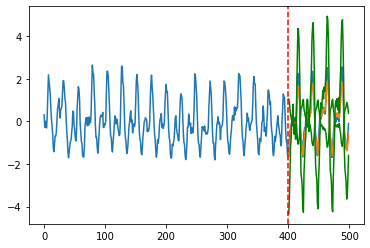

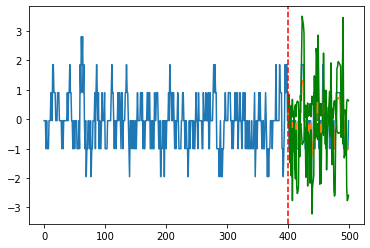

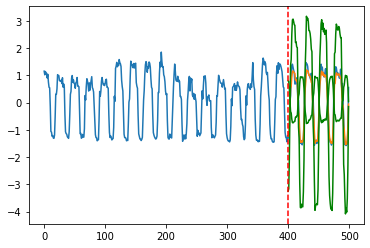

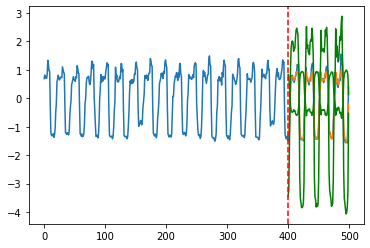

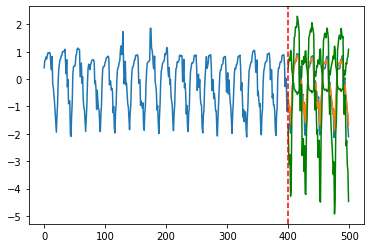

In [19]:
ind = 45
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 146
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 199
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 272
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()

ind = 304
plt.plot(np.arange(test_ds.shape[1]), test_ds[ind].detach().numpy())
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind])
# shows the 90% prediction interval
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] - 1.644854 * pred_mean[ind], color = 'green')
plt.plot(np.arange(test_ds.shape[1] - pred_len, test_ds.shape[1]), pred_mean[ind] + 1.644854 * pred_mean[ind], color = 'green')
plt.axvline(x=window_len, c='r', linestyle='--')
plt.show()
